In [1]:
import sys
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
from src.cohort import load_aki_cohort
from src.db import q
from src.utils import add_icu_los_days, add_dialysis_flag, add_early_dopamine_flag

df_aki = load_aki_cohort()
df_aki = add_icu_los_days(df_aki)
df_aki = add_dialysis_flag(df_aki)
df_aki = add_early_dopamine_flag(df_aki, window_hours=24)


In [3]:
df_aki.groupby("early_dopamine").agg(
    n=("early_dopamine", "count"),
    mortality=("hospital_mortality", "mean"),
    icu_los_median=("icu_los_days", "median"),
    dialysis_rate=("dialysis", "mean")
)


,n,mortality,icu_los_median,dialysis_rate
early_dopamine,,,,
0,10148,0.213047,3.006429,0.130075
1,337,0.394659,3.801389,0.195846


In [4]:
q("""
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public'
  AND table_name ILIKE '%oasis%'
     OR table_name ILIKE '%saps%'
     OR table_name ILIKE '%sofa%'
     OR table_name ILIKE '%severity%'
ORDER BY table_name
""")


,table_name
0,sofa


In [5]:
# Füge SOFA-Score zur AKI-Kohorte hinzu
from src.utils import add_sofa_score

# Du hast ja bereits df_aki geladen - einfach SOFA hinzufügen!
df_aki = add_sofa_score(df_aki)

# Jetzt hast du SOFA-Score in deinen Daten
print(df_aki[['icustay_id', 'sofa', 'sofa_respiration', 'sofa_renal']].head(10))

   icustay_id  sofa  sofa_respiration  sofa_renal
0      211552     7               0.0         3.0
1      220597     5               3.0         1.0
2      217847     7               2.0         3.0
3      248910     6               NaN         2.0
4      261857     7               NaN         0.0
5      272667     6               NaN         4.0
6      294232     3               NaN         2.0
7      294980     6               NaN         1.0
8      252051     3               0.0         1.0
9      277062     6               NaN         4.0



=== Outcomes by SOFA-RENAL Score ===

           icustay_id hospital_mortality      icu_los_days        dialysis  \
                count               mean  sum       median   mean     mean   
sofa_renal                                                                   
0.0              1463              0.214  313        3.650  7.788    0.066   
1.0              3598              0.158  567        2.798  5.597    0.049   
2.0              2618              0.180  472        3.002  5.569    0.086   
3.0              1519              0.303  461        3.638  6.685    0.213   
4.0              1244              0.387  481        2.903  5.932    0.447   

           early_dopamine  
                     mean  
sofa_renal                 
0.0                 0.012  
1.0                 0.023  
2.0                 0.037  
3.0                 0.046  
4.0                 0.056  


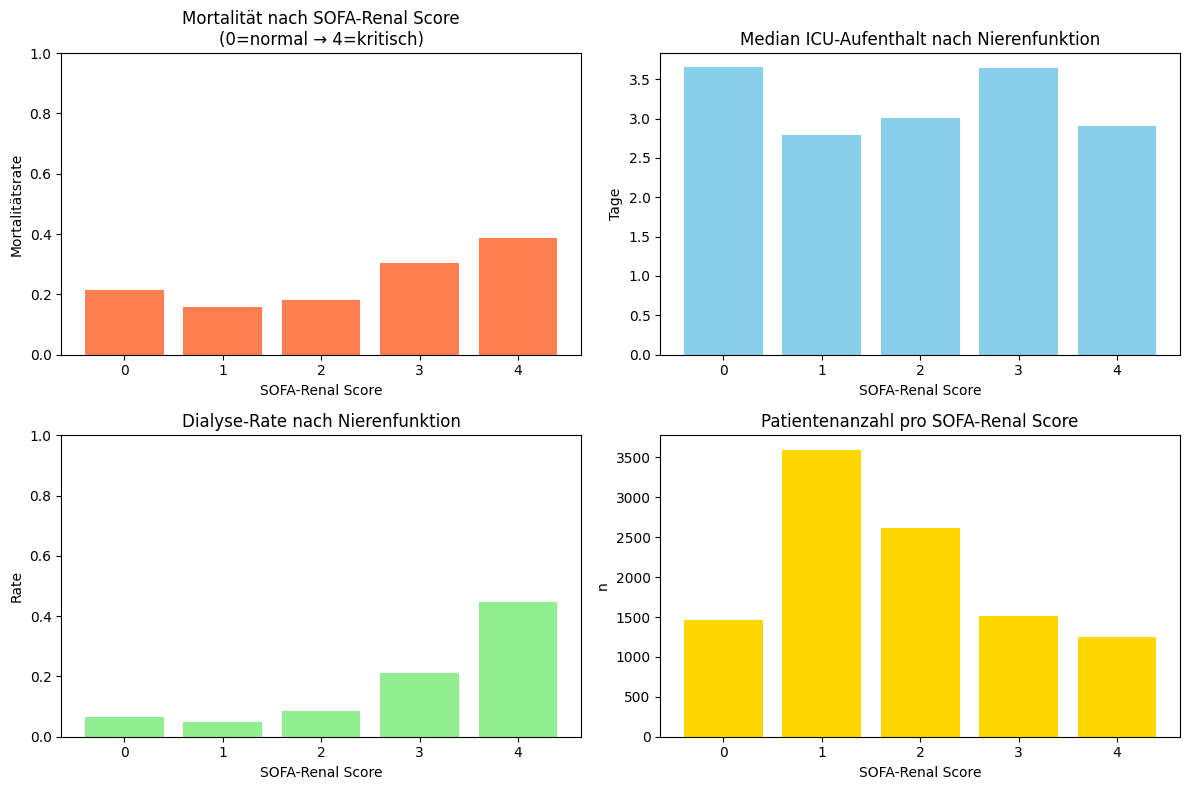


=== Interpretation ===
SOFA-Renal Score (0-4):
0 = Kreatinin < 1.2 mg/dL (normal)
1 = Kreatinin 1.2-1.9 mg/dL
2 = Kreatinin 2.0-3.4 mg/dL
3 = Kreatinin 3.5-4.9 mg/dL
4 = Kreatinin ≥ 5.0 mg/dL (ODER Urinausscheidung < 200 mL/Tag)


In [61]:
# Analyse: Mortalität vs. SOFA-RENAL-Score (Nierenfunktion)
# SOFA Renal: 0-4 Punkte, 4 = schlechteste Nierenfunktion

# Gruppiere nach SOFA-Renal-Score
renal_by_sofa = df_aki.groupby('sofa_renal', observed=True).agg({
    'icustay_id': 'count',
    'hospital_mortality': ['mean', 'sum'],
    'icu_los_days': ['median', 'mean'],
    'dialysis': 'mean',
    'early_dopamine': 'mean',
}).round(3)

print("\n=== Outcomes by SOFA-RENAL Score ===\n")
print(renal_by_sofa)

# Visualisierung
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Mortalität nach Nierenfunktion
sofa_renal_mort = df_aki.groupby('sofa_renal')['hospital_mortality'].agg(['mean', 'count'])
axes[0, 0].bar(sofa_renal_mort.index, sofa_renal_mort['mean'], color='coral')
axes[0, 0].set_title('Mortalität nach SOFA-Renal Score\n(0=normal → 4=kritisch)')
axes[0, 0].set_ylabel('Mortalitätsrate')
axes[0, 0].set_xlabel('SOFA-Renal Score')
axes[0, 0].set_ylim(0, 1)

# ICU LOS nach Nierenfunktion
sofa_renal_los = df_aki.groupby('sofa_renal')['icu_los_days'].median()
axes[0, 1].bar(sofa_renal_los.index, sofa_renal_los.values, color='skyblue')
axes[0, 1].set_title('Median ICU-Aufenthalt nach Nierenfunktion')
axes[0, 1].set_ylabel('Tage')
axes[0, 1].set_xlabel('SOFA-Renal Score')

# Dialyse-Rate nach Nierenfunktion
sofa_renal_dial = df_aki.groupby('sofa_renal')['dialysis'].mean()
axes[1, 0].bar(sofa_renal_dial.index, sofa_renal_dial.values, color='lightgreen')
axes[1, 0].set_title('Dialyse-Rate nach Nierenfunktion')
axes[1, 0].set_ylabel('Rate')
axes[1, 0].set_xlabel('SOFA-Renal Score')
axes[1, 0].set_ylim(0, 1)

# Patientenanzahl pro Score
sofa_renal_count = df_aki['sofa_renal'].value_counts().sort_index()
axes[1, 1].bar(sofa_renal_count.index, sofa_renal_count.values, color='gold')
axes[1, 1].set_title('Patientenanzahl pro SOFA-Renal Score')
axes[1, 1].set_ylabel('n')
axes[1, 1].set_xlabel('SOFA-Renal Score')

plt.tight_layout()
plt.show()

print("\n=== Interpretation ===")
print("SOFA-Renal Score (0-4):")
print("0 = Kreatinin < 1.2 mg/dL (normal)")
print("1 = Kreatinin 1.2-1.9 mg/dL")
print("2 = Kreatinin 2.0-3.4 mg/dL")
print("3 = Kreatinin 3.5-4.9 mg/dL")
print("4 = Kreatinin ≥ 5.0 mg/dL (ODER Urinausscheidung < 200 mL/Tag)")


=== Interventionen nach SOFA-Renal Score (AKI-Kohorte) ===

            dialysis_n  dialysis_rate  early_dopamine_n  early_dopamine_rate  \
sofa_renal                                                                     
0.0                 97          0.066                17                0.012   
1.0                175          0.049                82                0.023   
2.0                225          0.086                98                0.037   
3.0                323          0.213                70                0.046   
4.0                556          0.447                70                0.056   

            total_n  
sofa_renal           
0.0            1463  
1.0            3598  
2.0            2618  
3.0            1519  
4.0            1244  


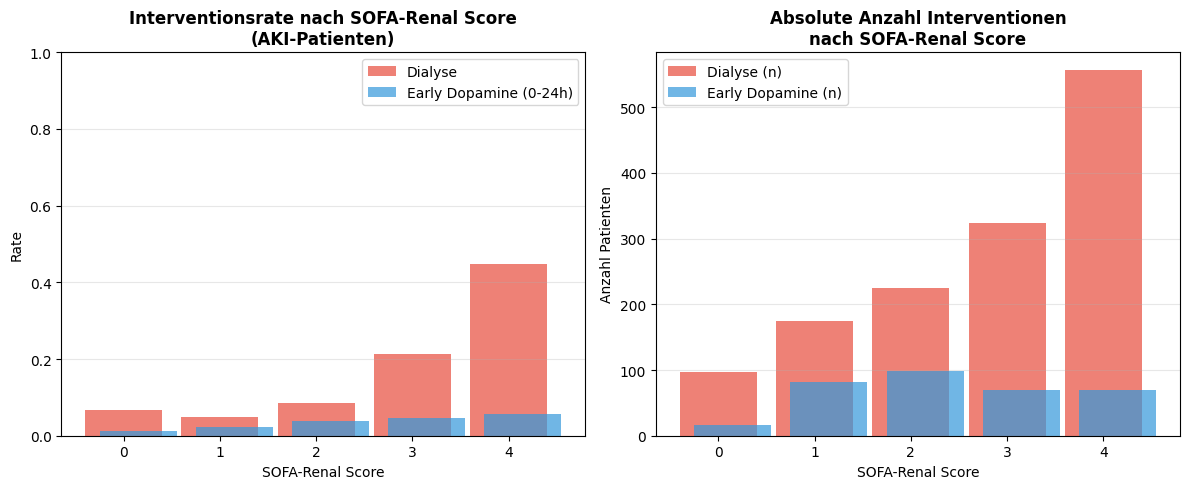


=== Detailierte Übersicht ===

SOFA-Renal Score 0:
  Patienten: 1463
  Dialyse: 97 (6.6%)
  Early Dopamine: 17 (1.2%)
  Mortalität: 21.4%)

SOFA-Renal Score 1:
  Patienten: 3598
  Dialyse: 175 (4.9%)
  Early Dopamine: 82 (2.3%)
  Mortalität: 15.8%)

SOFA-Renal Score 2:
  Patienten: 2618
  Dialyse: 225 (8.6%)
  Early Dopamine: 98 (3.7%)
  Mortalität: 18.0%)

SOFA-Renal Score 3:
  Patienten: 1519
  Dialyse: 323 (21.3%)
  Early Dopamine: 70 (4.6%)
  Mortalität: 30.3%)

SOFA-Renal Score 4:
  Patienten: 1244
  Dialyse: 556 (44.7%)
  Early Dopamine: 70 (5.6%)
  Mortalität: 38.7%)



In [7]:
# Interventionen nach SOFA-Renal Score
# Zeige welche Behandlungen die Patienten mit unterschiedlichem Nierenschaden bekommen haben

print("\n=== Interventionen nach SOFA-Renal Score (AKI-Kohorte) ===\n")

interventions = df_aki.groupby('sofa_renal').agg({
    'dialysis': ['sum', 'mean'],
    'early_dopamine': ['sum', 'mean'],
    'icustay_id': 'count'
}).round(3)

interventions.columns = ['dialysis_n', 'dialysis_rate', 'early_dopamine_n', 'early_dopamine_rate', 'total_n']
print(interventions)

# Visualisierung
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Dialyse nach Nierenfunktion
sofa_renal_dial = df_aki.groupby('sofa_renal')['dialysis'].mean()
axes[0].bar(sofa_renal_dial.index, sofa_renal_dial.values, color='#e74c3c', alpha=0.7, label='Dialyse')

# Early Dopamine overlaid
sofa_renal_dopa = df_aki.groupby('sofa_renal')['early_dopamine'].mean()
axes[0].bar(sofa_renal_dopa.index + 0.15, sofa_renal_dopa.values, color='#3498db', alpha=0.7, label='Early Dopamine (0-24h)')

axes[0].set_title('Interventionsrate nach SOFA-Renal Score\n(AKI-Patienten)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Rate')
axes[0].set_xlabel('SOFA-Renal Score')
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Absolute Zahlen
dialysis_counts = df_aki.groupby('sofa_renal')['dialysis'].sum()
dopamine_counts = df_aki.groupby('sofa_renal')['early_dopamine'].sum()

axes[1].bar(dialysis_counts.index, dialysis_counts.values, color='#e74c3c', alpha=0.7, label='Dialyse (n)')
axes[1].bar(dopamine_counts.index + 0.15, dopamine_counts.values, color='#3498db', alpha=0.7, label='Early Dopamine (n)')

axes[1].set_title('Absolute Anzahl Interventionen\nnach SOFA-Renal Score', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Anzahl Patienten')
axes[1].set_xlabel('SOFA-Renal Score')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Detail-Tabelle
print("\n=== Detailierte Übersicht ===\n")
for score in sorted(df_aki['sofa_renal'].dropna().unique()):
    subset = df_aki[df_aki['sofa_renal'] == score]
    n_total = len(subset)
    n_dialysis = subset['dialysis'].sum()
    n_dopamine = subset['early_dopamine'].sum()
    mortality = subset['hospital_mortality'].mean()
    
    print(f"SOFA-Renal Score {int(score)}:")
    print(f"  Patienten: {n_total}")
    print(f"  Dialyse: {n_dialysis} ({n_dialysis/n_total*100:.1f}%)")
    print(f"  Early Dopamine: {n_dopamine} ({n_dopamine/n_total*100:.1f}%)")
    print(f"  Mortalität: {mortality*100:.1f}%)")
    print()


=== Lade zusätzliche Interventionen ===


=== Alle Interventionen nach SOFA-Renal Score (AKI-Kohorte) ===

            Dialyse  Dopamine  Norepinephrine  Epinephrine  Vasopressor  \
sofa_renal                                                                
0.0           0.066     0.012           0.065        0.012        0.127   
1.0           0.049     0.023           0.087        0.013        0.136   
2.0           0.086     0.037           0.100        0.012        0.139   
3.0           0.213     0.046           0.142        0.014        0.176   
4.0           0.447     0.056           0.182        0.012        0.207   

            Beatmung     n  
sofa_renal                  
0.0            0.548  1463  
1.0            0.444  3598  
2.0            0.448  2618  
3.0            0.510  1519  
4.0            0.498  1244  

=== Absolute Zahlen ===

SOFA-Renal Score 0: n=1463
  Dialyse:             97 (  6.6%)
  Dopamine:            17 (  1.2%)
  Norepinephrine:      95 (  6.5%)
  Vas

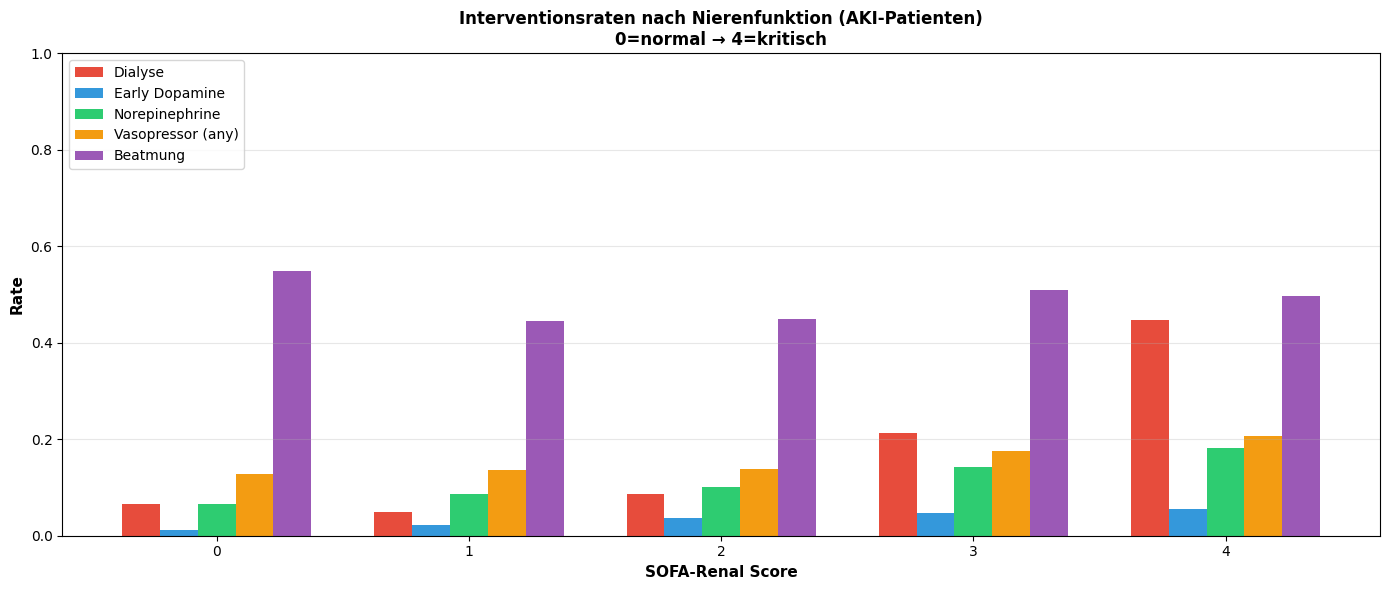

In [8]:
# Erweiterte Interventionsanalyse - Vasopressoren, Beatmung, etc.
from src.utils import add_vasopressor_flags, add_mechanical_ventilation_flag

print("\n=== Lade zusätzliche Interventionen ===\n")
df_aki = add_vasopressor_flags(df_aki, window_hours=24)
df_aki = add_mechanical_ventilation_flag(df_aki)

# Übersicht aller Interventionen nach SOFA-Renal Score
print("\n=== Alle Interventionen nach SOFA-Renal Score (AKI-Kohorte) ===\n")

interventions_full = df_aki.groupby('sofa_renal').agg({
    'dialysis': 'mean',
    'early_dopamine': 'mean',
    'early_norepinephrine': 'mean',
    'early_epinephrine': 'mean',
    'any_vasopressor': 'mean',
    'mechanical_ventilation': 'mean',
    'icustay_id': 'count'
}).round(3)

interventions_full.columns = ['Dialyse', 'Dopamine', 'Norepinephrine', 'Epinephrine', 'Vasopressor', 'Beatmung', 'n']
print(interventions_full)
print()

# Detailierte Zahlen
print("=== Absolute Zahlen ===\n")
for score in sorted(df_aki['sofa_renal'].dropna().unique()):
    subset = df_aki[df_aki['sofa_renal'] == score]
    n_total = len(subset)
    
    print(f"SOFA-Renal Score {int(score)}: n={n_total}")
    print(f"  Dialyse:           {subset['dialysis'].sum():4.0f} ({subset['dialysis'].mean()*100:5.1f}%)")
    print(f"  Dopamine:          {subset['early_dopamine'].sum():4.0f} ({subset['early_dopamine'].mean()*100:5.1f}%)")
    print(f"  Norepinephrine:    {subset['early_norepinephrine'].sum():4.0f} ({subset['early_norepinephrine'].mean()*100:5.1f}%)")
    print(f"  Vasopressor (any): {subset['any_vasopressor'].sum():4.0f} ({subset['any_vasopressor'].mean()*100:5.1f}%)")
    print(f"  Beatmung:          {subset['mechanical_ventilation'].sum():4.0f} ({subset['mechanical_ventilation'].mean()*100:5.1f}%)")
    print()

# Visualisierung
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))

interventions_by_score = df_aki.groupby('sofa_renal')[
    ['dialysis', 'early_dopamine', 'early_norepinephrine', 'any_vasopressor', 'mechanical_ventilation']
].mean()

x = interventions_by_score.index
width = 0.15

bars1 = ax.bar(x - 2*width, interventions_by_score['dialysis'], width, label='Dialyse', color='#e74c3c')
bars2 = ax.bar(x - width, interventions_by_score['early_dopamine'], width, label='Early Dopamine', color='#3498db')
bars3 = ax.bar(x, interventions_by_score['early_norepinephrine'], width, label='Norepinephrine', color='#2ecc71')
bars4 = ax.bar(x + width, interventions_by_score['any_vasopressor'], width, label='Vasopressor (any)', color='#f39c12')
bars5 = ax.bar(x + 2*width, interventions_by_score['mechanical_ventilation'], width, label='Beatmung', color='#9b59b6')

ax.set_ylabel('Rate', fontsize=11, fontweight='bold')
ax.set_xlabel('SOFA-Renal Score', fontsize=11, fontweight='bold')
ax.set_title('Interventionsraten nach Nierenfunktion (AKI-Patienten)\n0=normal → 4=kritisch', 
             fontsize=12, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.legend(loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Interventions-Effekt-Analyse: Vergleiche INNERHALB gleicher SOFA-Renal Score Kategorien
# WICHTIG: Nur Patienten mit gleichem Nierenschaden-Schweregrad vergleichen!
from scipy.stats import chi2_contingency, ttest_ind
import numpy as np

print("\n" + "="*80)
print("INTERVENTIONS-EFFEKT-ANALYSE - STRATIFIZIERT NACH SOFA-RENAL SCORE")
print("(Vergleiche nur Patienten mit gleichem Nierenschaden-Schweregrad)")
print("="*80 + "\n")

def compare_groups_within_sofa(df, intervention_col, intervention_name, sofa_score):
    """Vergleiche Outcomes zwischen Gruppen mit/ohne Intervention INNERHALB gleicher SOFA-Renal Kategorie"""
    
    # Filter auf diese SOFA-Kategorie
    df_subset = df[df['sofa_renal'] == sofa_score].copy()
    
    if len(df_subset) == 0:
        print(f"  Keine Patienten mit SOFA-Renal={int(sofa_score)}")
        return
    
    with_intervention = df_subset[df_subset[intervention_col] == 1]
    without_intervention = df_subset[df_subset[intervention_col] == 0]
    
    n_with = len(with_intervention)
    n_without = len(without_intervention)
    
    if n_with < 2 or n_without < 2:
        print(f"  ⚠ Zu kleine Gruppen (mit={n_with}, ohne={n_without})")
        return
    
    # Mortalität (kategorisch)
    mortality_with = with_intervention['hospital_mortality'].mean()
    mortality_without = without_intervention['hospital_mortality'].mean()
    mortality_diff = mortality_with - mortality_without
    
    try:
        contingency = pd.crosstab(df_subset[intervention_col], df_subset['hospital_mortality'])
        chi2, p_value_mort, dof, expected = chi2_contingency(contingency)
    except:
        p_value_mort = np.nan
    
    print(f"  Mortalität:")
    print(f"    Mit {intervention_name:25s}: {mortality_with*100:6.1f}% (n={n_with}, {with_intervention['hospital_mortality'].sum():.0f} Todesfälle)")
    print(f"    Ohne {intervention_name:24s}: {mortality_without*100:6.1f}% (n={n_without}, {without_intervention['hospital_mortality'].sum():.0f} Todesfälle)")
    print(f"    Differenz:                       {mortality_diff*100:+6.1f} pp, p={p_value_mort:.4f} {'***' if p_value_mort < 0.001 else '**' if p_value_mort < 0.01 else '*' if p_value_mort < 0.05 else ''}")
    
    # ICU LOS
    los_with = with_intervention['icu_los_days'].mean()
    los_without = without_intervention['icu_los_days'].mean()
    los_diff = los_with - los_without
    
    try:
        t_stat_los, p_value_los = ttest_ind(
            with_intervention['icu_los_days'].dropna(),
            without_intervention['icu_los_days'].dropna()
        )
    except:
        p_value_los = np.nan
    
    print(f"  ICU-Aufenthalt:")
    print(f"    Mit Intervention:    {los_with:6.1f} Tage (Med: {with_intervention['icu_los_days'].median():.1f})")
    print(f"    Ohne Intervention:   {los_without:6.1f} Tage (Med: {without_intervention['icu_los_days'].median():.1f})")
    print(f"    Differenz:           {los_diff:+6.1f} Tage, p={p_value_los:.4f} {'***' if p_value_los < 0.001 else '**' if p_value_los < 0.01 else '*' if p_value_los < 0.05 else ''}")

# Stratifizieren nach Intervention
interventions = ['dialysis', 'any_vasopressor', 'early_dopamine', 'mechanical_ventilation']
intervention_names = ['Dialyse', 'Vasopressor (früh)', 'Early Dopamine', 'Mechanische Beatmung']

for intervention_col, intervention_name in zip(interventions, intervention_names):
    print(f"\n{'='*80}")
    print(f"INTERVENTION: {intervention_name}")
    print(f"{'='*80}")
    
    # Für jede SOFA-Renal Kategorie
    for sofa_score in sorted(df_aki['sofa_renal'].dropna().unique()):
        sofa_labels = {0.0: 'normal', 1.0: 'mild', 2.0: 'moderat', 3.0: 'schwer', 4.0: 'kritisch'}
        label = sofa_labels.get(sofa_score, '')
        print(f"\nSOFA-Renal Score {int(sofa_score)} ({label}):")
        compare_groups_within_sofa(df_aki, intervention_col, intervention_name, sofa_score)

print("\n" + "="*80)
print("*** p<0.001 (hochsignifikant) | ** p<0.01 (signifikant) | * p<0.05 (schwach signifikant)")
print("pp = Prozentpunkte")
print("="*80)


INTERVENTIONS-EFFEKT-ANALYSE - STRATIFIZIERT NACH SOFA-RENAL SCORE
(Vergleiche nur Patienten mit gleichem Nierenschaden-Schweregrad)


INTERVENTION: Dialyse

SOFA-Renal Score 0 (normal):
  Mortalität:
    Mit Dialyse                  :   47.4% (n=97, 46 Todesfälle)
    Ohne Dialyse                 :   19.5% (n=1366, 267 Todesfälle)
    Differenz:                        +27.9 pp, p=0.0000 ***
  ICU-Aufenthalt:
    Mit Intervention:      18.3 Tage (Med: 13.9)
    Ohne Intervention:      7.0 Tage (Med: 3.3)
    Differenz:            +11.3 Tage, p=0.0000 ***

SOFA-Renal Score 1 (mild):
  Mortalität:
    Mit Dialyse                  :   46.3% (n=175, 81 Todesfälle)
    Ohne Dialyse                 :   14.2% (n=3423, 486 Todesfälle)
    Differenz:                        +32.1 pp, p=0.0000 ***
  ICU-Aufenthalt:
    Mit Intervention:      17.1 Tage (Med: 11.8)
    Ohne Intervention:      5.0 Tage (Med: 2.7)
    Differenz:            +12.1 Tage, p=0.0000 ***

SOFA-Renal Score 2 (moderat):
  Mo


FOKUS-ANALYSE: EARLY VASOPRESSOR (Erste 24h nach ICU-Aufnahme)
Stratifiziert nach GESAMT SOFA Score (Organ-Funktionsstatus)


SOFA-Kategorie: Mild (0-3)

Gruppengrößen:
  Mit Early Vasopressor:    n =    84 (  2.9%)
  Ohne Early Vasopressor:   n =  2843 ( 97.1%)
  Gesamt:                   n =  2927

📊 MORTALITÄT:
  Mit Vasopressor:             9.5% (8/84 Todesfälle)
  Ohne Vasopressor:           10.0% (283/2843 Todesfälle)
  Absolute Differenz:         -0.4 Prozentpunkte
  Relatives Risiko (RR):    0.96x
  p-value (Chi²-Test):      1.0000 

⏱️ ICU-AUFENTHALT (Tage):
  Mit Vasopressor:          Mittel=   5.4, Median=   2.8
  Ohne Vasopressor:         Mittel=   4.2, Median=   2.1
  Differenz:                  +1.2 Tage
  p-value (t-Test):         0.1124 

💊 DIALYSEPFLICHT:
  Mit Vasopressor:             2.4% (2/84)
  Ohne Vasopressor:            4.6% (130/2843)
  Differenz:                  -2.2 Prozentpunkte
  p-value (Chi²-Test):      0.4919 

🫀 SOFA-RENAL SCORE (Nierenfunktion):
  M

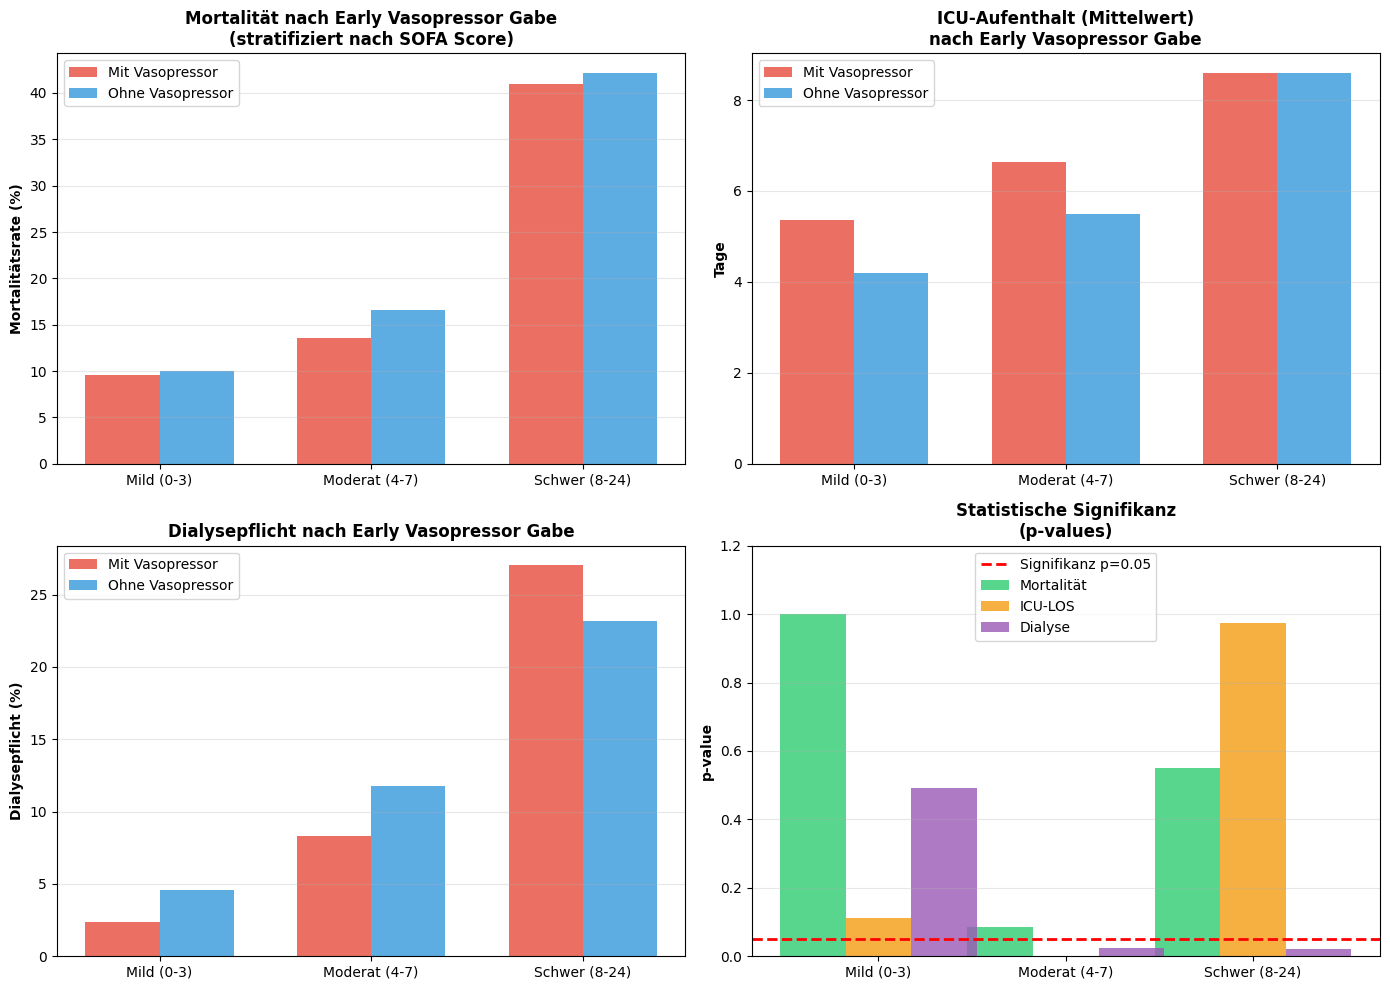


Signifikanzniveau: *** p<0.001 | ** p<0.01 | * p<0.05


In [11]:
# FOKUS: Early Vasopressor (erste 24h) - Stratifiziert nach GESAMT SOFA Score
from scipy.stats import chi2_contingency, ttest_ind
import matplotlib.pyplot as plt

print("\n" + "="*100)
print("FOKUS-ANALYSE: EARLY VASOPRESSOR (Erste 24h nach ICU-Aufnahme)")
print("Stratifiziert nach GESAMT SOFA Score (Organ-Funktionsstatus)")
print("="*100 + "\n")

# Erstelle SOFA-Kategorien basierend auf Gesamtscore
df_aki['sofa_category'] = pd.cut(
    df_aki['sofa'], 
    bins=[-0.1, 3, 7, 24], 
    labels=['Mild (0-3)', 'Moderat (4-7)', 'Schwer (8-24)']
)

# Detaillierte Analyse für jede SOFA-Kategorie
sofa_categories = ['Mild (0-3)', 'Moderat (4-7)', 'Schwer (8-24)']

results = []

for sofa_cat in sofa_categories:
    df_subset = df_aki[df_aki['sofa_category'] == sofa_cat].copy()
    
    if len(df_subset) == 0:
        continue
    
    with_vaso = df_subset[df_subset['any_vasopressor'] == 1]
    without_vaso = df_subset[df_subset['any_vasopressor'] == 0]
    
    n_with = len(with_vaso)
    n_without = len(without_vaso)
    
    if n_with < 2 or n_without < 2:
        continue
    
    print(f"\n{'='*100}")
    print(f"SOFA-Kategorie: {sofa_cat}")
    print(f"{'='*100}")
    print(f"\nGruppengrößen:")
    print(f"  Mit Early Vasopressor:    n = {n_with:5.0f} ({n_with/(n_with+n_without)*100:5.1f}%)")
    print(f"  Ohne Early Vasopressor:   n = {n_without:5.0f} ({n_without/(n_with+n_without)*100:5.1f}%)")
    print(f"  Gesamt:                   n = {len(df_subset):5.0f}")
    
    # 1. MORTALITÄT
    mort_with = with_vaso['hospital_mortality'].mean()
    mort_without = without_vaso['hospital_mortality'].mean()
    mort_diff = mort_with - mort_without
    
    try:
        contingency = pd.crosstab(df_subset['any_vasopressor'], df_subset['hospital_mortality'])
        chi2, p_mort, dof, expected = chi2_contingency(contingency)
    except:
        p_mort = np.nan
    
    sig_mort = '***' if p_mort < 0.001 else '**' if p_mort < 0.01 else '*' if p_mort < 0.05 else ''
    
    print(f"\n📊 MORTALITÄT:")
    print(f"  Mit Vasopressor:          {mort_with*100:6.1f}% ({with_vaso['hospital_mortality'].sum():.0f}/{n_with} Todesfälle)")
    print(f"  Ohne Vasopressor:         {mort_without*100:6.1f}% ({without_vaso['hospital_mortality'].sum():.0f}/{n_without} Todesfälle)")
    print(f"  Absolute Differenz:       {mort_diff*100:+6.1f} Prozentpunkte")
    if mort_without > 0:
        rr = mort_with / mort_without
        print(f"  Relatives Risiko (RR):    {rr:.2f}x")
    print(f"  p-value (Chi²-Test):      {p_mort:.4f} {sig_mort}")
    
    # 2. ICU-LOS
    los_with = with_vaso['icu_los_days'].mean()
    los_without = without_vaso['icu_los_days'].mean()
    los_diff = los_with - los_without
    los_med_with = with_vaso['icu_los_days'].median()
    los_med_without = without_vaso['icu_los_days'].median()
    
    try:
        t_los, p_los = ttest_ind(with_vaso['icu_los_days'].dropna(), 
                                  without_vaso['icu_los_days'].dropna())
    except:
        p_los = np.nan
    
    sig_los = '***' if p_los < 0.001 else '**' if p_los < 0.01 else '*' if p_los < 0.05 else ''
    
    print(f"\n⏱️ ICU-AUFENTHALT (Tage):")
    print(f"  Mit Vasopressor:          Mittel={los_with:6.1f}, Median={los_med_with:6.1f}")
    print(f"  Ohne Vasopressor:         Mittel={los_without:6.1f}, Median={los_med_without:6.1f}")
    print(f"  Differenz:                {los_diff:+6.1f} Tage")
    print(f"  p-value (t-Test):         {p_los:.4f} {sig_los}")
    
    # 3. DIALYSEPFLICHT
    dial_with = with_vaso['dialysis'].mean()
    dial_without = without_vaso['dialysis'].mean()
    dial_diff = dial_with - dial_without
    
    try:
        contingency_dial = pd.crosstab(df_subset['any_vasopressor'], df_subset['dialysis'])
        chi2_dial, p_dial, dof_dial, expected_dial = chi2_contingency(contingency_dial)
    except:
        p_dial = np.nan
    
    sig_dial = '***' if p_dial < 0.001 else '**' if p_dial < 0.01 else '*' if p_dial < 0.05 else ''
    
    print(f"\n💊 DIALYSEPFLICHT:")
    print(f"  Mit Vasopressor:          {dial_with*100:6.1f}% ({with_vaso['dialysis'].sum():.0f}/{n_with})")
    print(f"  Ohne Vasopressor:         {dial_without*100:6.1f}% ({without_vaso['dialysis'].sum():.0f}/{n_without})")
    print(f"  Differenz:                {dial_diff*100:+6.1f} Prozentpunkte")
    print(f"  p-value (Chi²-Test):      {p_dial:.4f} {sig_dial}")
    
    # 4. RENAL SOFA SCORE
    sofa_renal_with = with_vaso['sofa_renal'].mean()
    sofa_renal_without = without_vaso['sofa_renal'].mean()
    
    try:
        t_sofa_renal, p_sofa_renal = ttest_ind(with_vaso['sofa_renal'].dropna(), 
                                                without_vaso['sofa_renal'].dropna())
    except:
        p_sofa_renal = np.nan
    
    sig_sofa_renal = '***' if p_sofa_renal < 0.001 else '**' if p_sofa_renal < 0.01 else '*' if p_sofa_renal < 0.05 else ''
    
    print(f"\n🫀 SOFA-RENAL SCORE (Nierenfunktion):")
    print(f"  Mit Vasopressor:          {sofa_renal_with:6.2f}")
    print(f"  Ohne Vasopressor:         {sofa_renal_without:6.2f}")
    print(f"  p-value (t-Test):         {p_sofa_renal:.4f} {sig_sofa_renal}")
    
    # Speichere Resultate für Visualisierung
    results.append({
        'sofa_cat': sofa_cat,
        'n_with': n_with,
        'n_without': n_without,
        'mort_with': mort_with,
        'mort_without': mort_without,
        'los_with': los_with,
        'los_without': los_without,
        'dial_with': dial_with,
        'dial_without': dial_without,
        'p_mort': p_mort,
        'p_los': p_los,
        'p_dial': p_dial
    })

# Visualisierungen
if results:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    sofa_cats_list = [r['sofa_cat'] for r in results]
    x = range(len(sofa_cats_list))
    width = 0.35
    
    # 1. Mortalität
    mort_with_list = [r['mort_with']*100 for r in results]
    mort_without_list = [r['mort_without']*100 for r in results]
    
    axes[0, 0].bar([i - width/2 for i in x], mort_with_list, width, label='Mit Vasopressor', color='#e74c3c', alpha=0.8)
    axes[0, 0].bar([i + width/2 for i in x], mort_without_list, width, label='Ohne Vasopressor', color='#3498db', alpha=0.8)
    axes[0, 0].set_ylabel('Mortalitätsrate (%)', fontweight='bold')
    axes[0, 0].set_title('Mortalität nach Early Vasopressor Gabe\n(stratifiziert nach SOFA Score)', fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(sofa_cats_list)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # 2. ICU-LOS
    los_with_list = [r['los_with'] for r in results]
    los_without_list = [r['los_without'] for r in results]
    
    axes[0, 1].bar([i - width/2 for i in x], los_with_list, width, label='Mit Vasopressor', color='#e74c3c', alpha=0.8)
    axes[0, 1].bar([i + width/2 for i in x], los_without_list, width, label='Ohne Vasopressor', color='#3498db', alpha=0.8)
    axes[0, 1].set_ylabel('Tage', fontweight='bold')
    axes[0, 1].set_title('ICU-Aufenthalt (Mittelwert)\nnach Early Vasopressor Gabe', fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(sofa_cats_list)
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Dialysepflicht
    dial_with_list = [r['dial_with']*100 for r in results]
    dial_without_list = [r['dial_without']*100 for r in results]
    
    axes[1, 0].bar([i - width/2 for i in x], dial_with_list, width, label='Mit Vasopressor', color='#e74c3c', alpha=0.8)
    axes[1, 0].bar([i + width/2 for i in x], dial_without_list, width, label='Ohne Vasopressor', color='#3498db', alpha=0.8)
    axes[1, 0].set_ylabel('Dialysepflicht (%)', fontweight='bold')
    axes[1, 0].set_title('Dialysepflicht nach Early Vasopressor Gabe', fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(sofa_cats_list)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. P-values
    p_mort_list = [r['p_mort'] for r in results]
    p_los_list = [r['p_los'] for r in results]
    p_dial_list = [r['p_dial'] for r in results]
    
    axes[1, 1].bar([i - width for i in x], p_mort_list, width, label='Mortalität', color='#2ecc71', alpha=0.8)
    axes[1, 1].bar([i for i in x], p_los_list, width, label='ICU-LOS', color='#f39c12', alpha=0.8)
    axes[1, 1].bar([i + width for i in x], p_dial_list, width, label='Dialyse', color='#9b59b6', alpha=0.8)
    axes[1, 1].axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='Signifikanz p=0.05')
    axes[1, 1].set_ylabel('p-value', fontweight='bold')
    axes[1, 1].set_title('Statistische Signifikanz\n(p-values)', fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(sofa_cats_list)
    axes[1, 1].set_ylim(0, max(0.1, max(p_mort_list + p_los_list + p_dial_list)) * 1.2)
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*100)
print("Signifikanzniveau: *** p<0.001 | ** p<0.01 | * p<0.05")
print("="*100)


2D-STRATIFIZIERTE ANALYSE: EARLY VASOPRESSOR
Nach SOFA-Renal Score (Nierenfunktion) UND Gesamt-SOFA Score (Gesamtschweregrad)


Renal: Mild (0-1)      | Gesamt: Mild (0-3)      | n=2272 (Mit Vaso: 76, Ohne: 2196)
Mortalität:     Mit   9.2% vs Ohne  10.7% (Δ  -1.5pp, p=0.812 )
ICU-LOS (Tage):  Mit   5.7   vs Ohne   4.4   (Δ  +1.3 Tage, p=0.103 )
Dialysepflicht: Mit   2.6% vs Ohne   3.3% (Δ  -0.7pp, p=0.995 )

Renal: Mild (0-1)      | Gesamt: Moderat (4-7)   | n=1987 (Mit Vaso: 328, Ohne: 1659)
Mortalität:     Mit  13.4% vs Ohne  18.2% (Δ  -4.8pp, p=0.044 *)
ICU-LOS (Tage):  Mit   7.3   vs Ohne   6.7   (Δ  +0.6 Tage, p=0.276 )
Dialysepflicht: Mit   6.1% vs Ohne   5.1% (Δ  +1.0pp, p=0.527 )

Renal: Mild (0-1)      | Gesamt: Schwer (8-24)   | n= 802 (Mit Vaso: 271, Ohne: 531)
Mortalität:     Mit  30.3% vs Ohne  39.4% (Δ  -9.1pp, p=0.014 *)
ICU-LOS (Tage):  Mit  10.0   vs Ohne  10.1   (Δ  -0.1 Tage, p=0.903 )
Dialysepflicht: Mit  10.3% vs Ohne  12.2% (Δ  -1.9pp, p=0.495 )

Renal: Moderat (


2D-STRATIFIZIERTE ANALYSE: EARLY VASOPRESSOR
Nach SOFA-Renal Score (Nierenfunktion) UND Gesamt-SOFA Score (Gesamtschweregrad)


Renal: Mild (0-1)      | Gesamt: Mild (0-3)      | n=2272 (Mit Vaso: 76, Ohne: 2196)
Mortalität:     Mit   9.2% vs Ohne  10.7% (Δ  -1.5pp, p=0.812 )
ICU-LOS (Tage):  Mit   5.7   vs Ohne   4.4   (Δ  +1.3 Tage, p=0.103 )
Dialysepflicht: Mit   2.6% vs Ohne   3.3% (Δ  -0.7pp, p=0.995 )

Renal: Mild (0-1)      | Gesamt: Moderat (4-7)   | n=1987 (Mit Vaso: 328, Ohne: 1659)
Mortalität:     Mit  13.4% vs Ohne  18.2% (Δ  -4.8pp, p=0.044 *)
ICU-LOS (Tage):  Mit   7.3   vs Ohne   6.7   (Δ  +0.6 Tage, p=0.276 )
Dialysepflicht: Mit   6.1% vs Ohne   5.1% (Δ  +1.0pp, p=0.527 )

Renal: Mild (0-1)      | Gesamt: Schwer (8-24)   | n= 802 (Mit Vaso: 271, Ohne: 531)
Mortalität:     Mit  30.3% vs Ohne  39.4% (Δ  -9.1pp, p=0.014 *)
ICU-LOS (Tage):  Mit  10.0   vs Ohne  10.1   (Δ  -0.1 Tage, p=0.903 )
Dialysepflicht: Mit  10.3% vs Ohne  12.2% (Δ  -1.9pp, p=0.495 )

Renal: Moderat (

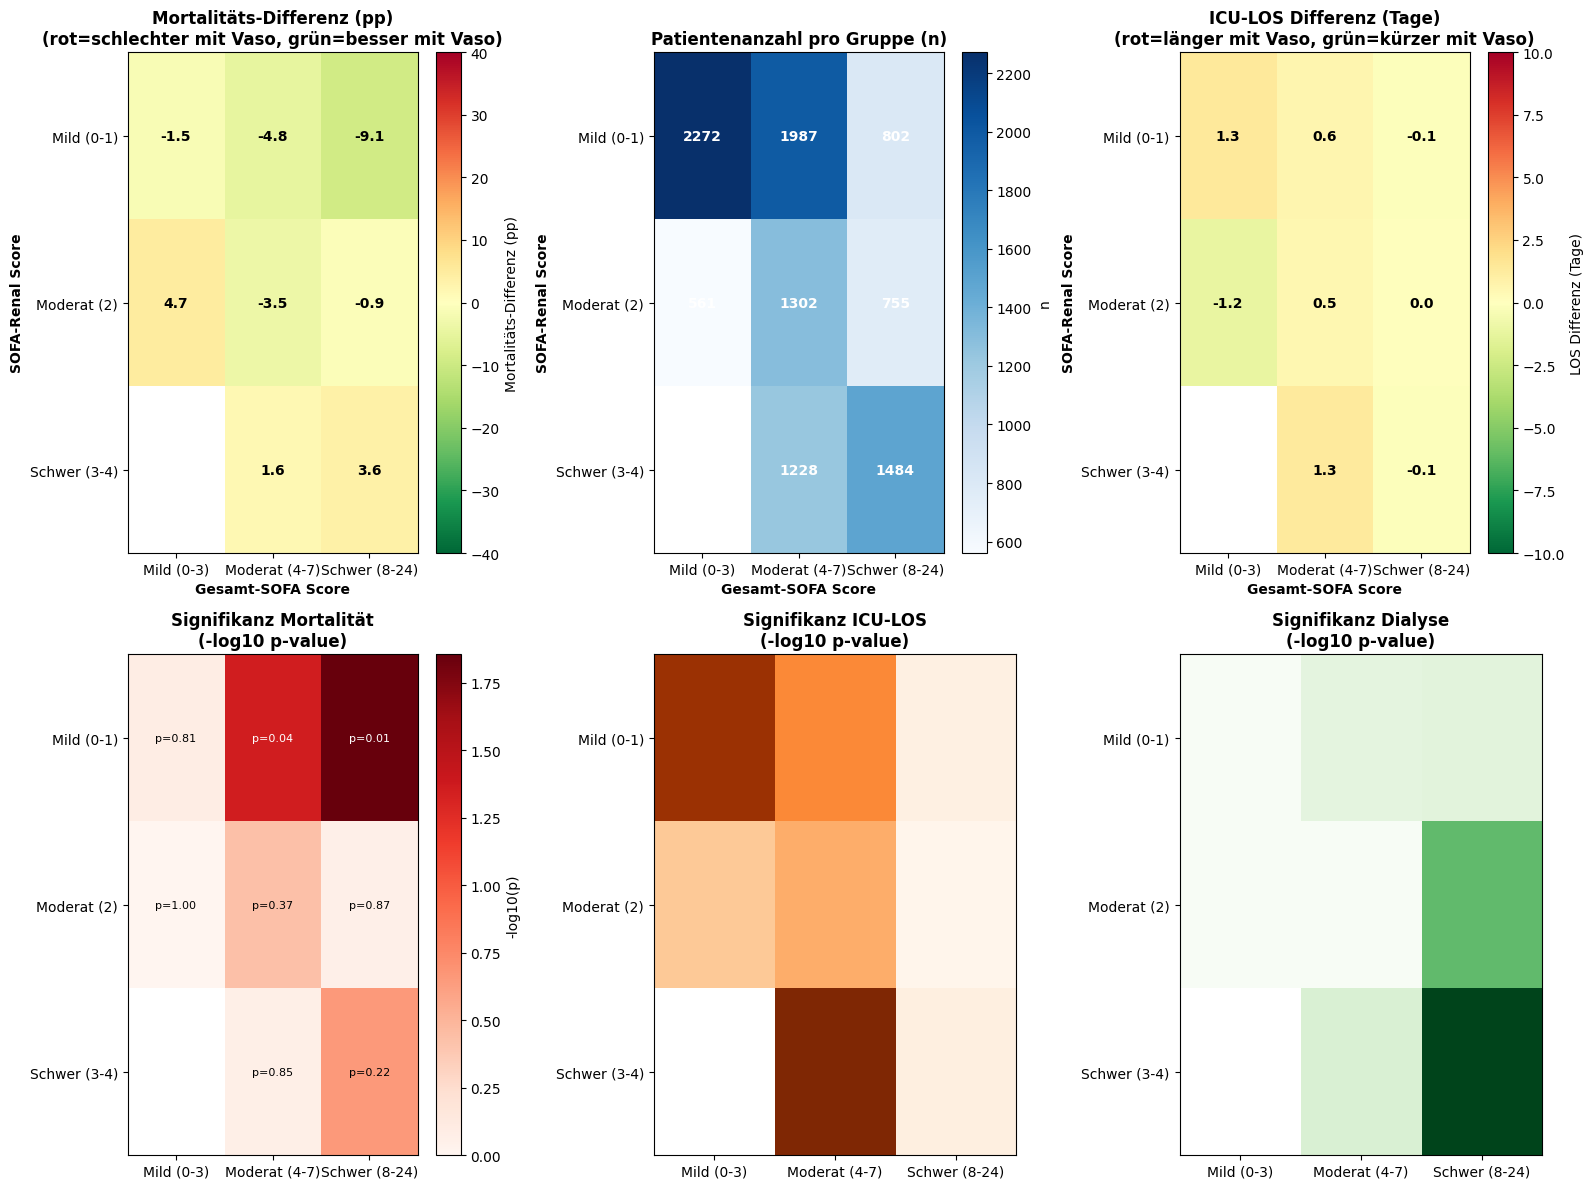


Signifikanzniveau: *** p<0.001 | ** p<0.01 | * p<0.05


In [12]:
# 2D STRATIFIZIERUNG: Early Vasopressor nach SOFA-Renal UND Gesamt-SOFA
# Das grenzt die Gruppen optimal ein: homogene Patienten vergleichen
from scipy.stats import chi2_contingency, ttest_ind
import matplotlib.pyplot as plt

print("\n" + "="*120)
print("2D-STRATIFIZIERTE ANALYSE: EARLY VASOPRESSOR")
print("Nach SOFA-Renal Score (Nierenfunktion) UND Gesamt-SOFA Score (Gesamtschweregrad)")
print("="*120 + "\n")

# Erstelle Kategorien
df_aki['sofa_renal_cat'] = pd.cut(
    df_aki['sofa_renal'], 
    bins=[-0.1, 1.5, 2.5, 4.1], 
    labels=['Mild (0-1)', 'Moderat (2)', 'Schwer (3-4)'],
    include_lowest=True
)

df_aki['sofa_gesamt_cat'] = pd.cut(
    df_aki['sofa'], 
    bins=[-0.1, 3, 7, 24], 
    labels=['Mild (0-3)', 'Moderat (4-7)', 'Schwer (8-24)']
)

# Sammle Ergebnisse für Visualisierung
results_2d = []

# Iteriere durch alle Kombinationen
for sofa_renal_cat in ['Mild (0-1)', 'Moderat (2)', 'Schwer (3-4)']:
    for sofa_gesamt_cat in ['Mild (0-3)', 'Moderat (4-7)', 'Schwer (8-24)']:
        
        # Filter Daten für diese 2D-Gruppe
        df_subset = df_aki[
            (df_aki['sofa_renal_cat'] == sofa_renal_cat) & 
            (df_aki['sofa_gesamt_cat'] == sofa_gesamt_cat)
        ].copy()
        
        if len(df_subset) < 10:  # Mindestgröße
            continue
        
        with_vaso = df_subset[df_subset['any_vasopressor'] == 1]
        without_vaso = df_subset[df_subset['any_vasopressor'] == 0]
        
        n_with = len(with_vaso)
        n_without = len(without_vaso)
        n_total = len(df_subset)
        
        # Überspringen wenn zu kleine Gruppen
        if n_with < 2 or n_without < 2:
            continue
        
        print(f"\n{'='*120}")
        print(f"Renal: {sofa_renal_cat:15s} | Gesamt: {sofa_gesamt_cat:15s} | n={n_total:4.0f} (Mit Vaso: {n_with}, Ohne: {n_without})")
        print(f"{'='*120}")
        
        # MORTALITÄT
        mort_with = with_vaso['hospital_mortality'].mean()
        mort_without = without_vaso['hospital_mortality'].mean()
        mort_diff = mort_with - mort_without
        
        try:
            contingency = pd.crosstab(df_subset['any_vasopressor'], df_subset['hospital_mortality'])
            chi2, p_mort, dof, expected = chi2_contingency(contingency)
        except:
            p_mort = np.nan
        
        sig_mort = '***' if p_mort < 0.001 else '**' if p_mort < 0.01 else '*' if p_mort < 0.05 else ''
        
        # ICU-LOS
        los_with = with_vaso['icu_los_days'].mean()
        los_without = without_vaso['icu_los_days'].mean()
        los_diff = los_with - los_without
        
        try:
            t_los, p_los = ttest_ind(with_vaso['icu_los_days'].dropna(), 
                                      without_vaso['icu_los_days'].dropna())
        except:
            p_los = np.nan
        
        sig_los = '***' if p_los < 0.001 else '**' if p_los < 0.01 else '*' if p_los < 0.05 else ''
        
        # DIALYSE
        dial_with = with_vaso['dialysis'].mean()
        dial_without = without_vaso['dialysis'].mean()
        dial_diff = dial_with - dial_without
        
        try:
            contingency_dial = pd.crosstab(df_subset['any_vasopressor'], df_subset['dialysis'])
            chi2_dial, p_dial, dof_dial, expected_dial = chi2_contingency(contingency_dial)
        except:
            p_dial = np.nan
        
        sig_dial = '***' if p_dial < 0.001 else '**' if p_dial < 0.01 else '*' if p_dial < 0.05 else ''
        
        print(f"Mortalität:     Mit {mort_with*100:5.1f}% vs Ohne {mort_without*100:5.1f}% (Δ {mort_diff*100:+5.1f}pp, p={p_mort:.3f} {sig_mort})")
        print(f"ICU-LOS (Tage):  Mit {los_with:5.1f}   vs Ohne {los_without:5.1f}   (Δ {los_diff:+5.1f} Tage, p={p_los:.3f} {sig_los})")
        print(f"Dialysepflicht: Mit {dial_with*100:5.1f}% vs Ohne {dial_without*100:5.1f}% (Δ {dial_diff*100:+5.1f}pp, p={p_dial:.3f} {sig_dial})")
        
        # Speichere für Visualisierung
        results_2d.append({
            'renal': sofa_renal_cat,
            'gesamt': sofa_gesamt_cat,
            'n_total': n_total,
            'n_with': n_with,
            'n_without': n_without,
            'mort_with': mort_with,
            'mort_without': mort_without,
            'mort_diff': mort_diff,
            'p_mort': p_mort,
            'los_diff': los_diff,
            'p_los': p_los,
            'dial_diff': dial_diff,
            'p_dial': p_dial
        })

# Erstelle Zusammenfassung als Heatmap-ähnliche Visualisierung
if results_2d:
    print("\n\n" + "="*120)
    print("ZUSAMMENFASSUNG: Mortalitäts-Differenz (Mit Vasopressor - Ohne Vasopressor) in Prozentpunkten")
    print("="*120)
    
    # Erstelle Matrix für Mortalitäts-Differenzen
    renal_cats = ['Mild (0-1)', 'Moderat (2)', 'Schwer (3-4)']
    gesamt_cats = ['Mild (0-3)', 'Moderat (4-7)', 'Schwer (8-24)']
    
    mort_matrix = np.full((len(renal_cats), len(gesamt_cats)), np.nan)
    n_matrix = np.full((len(renal_cats), len(gesamt_cats)), np.nan)
    
    for result in results_2d:
        r_idx = renal_cats.index(result['renal'])
        g_idx = gesamt_cats.index(result['gesamt'])
        mort_matrix[r_idx, g_idx] = result['mort_diff'] * 100
        n_matrix[r_idx, g_idx] = result['n_total']
    
    # Visualisierungen
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Heatmap Mortalitäts-Differenz
    ax1 = plt.subplot(2, 3, 1)
    im1 = ax1.imshow(mort_matrix, cmap='RdYlGn_r', aspect='auto', vmin=-40, vmax=40)
    ax1.set_xticks(range(len(gesamt_cats)))
    ax1.set_yticks(range(len(renal_cats)))
    ax1.set_xticklabels(gesamt_cats)
    ax1.set_yticklabels(renal_cats)
    ax1.set_xlabel('Gesamt-SOFA Score', fontweight='bold')
    ax1.set_ylabel('SOFA-Renal Score', fontweight='bold')
    ax1.set_title('Mortalitäts-Differenz (pp)\n(rot=schlechter mit Vaso, grün=besser mit Vaso)', fontweight='bold')
    
    # Werte eintragen
    for i in range(len(renal_cats)):
        for j in range(len(gesamt_cats)):
            if not np.isnan(mort_matrix[i, j]):
                text = ax1.text(j, i, f'{mort_matrix[i, j]:.1f}', ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im1, ax=ax1, label='Mortalitäts-Differenz (pp)')
    
    # 2. Heatmap Patientenanzahl
    ax2 = plt.subplot(2, 3, 2)
    im2 = ax2.imshow(n_matrix, cmap='Blues', aspect='auto')
    ax2.set_xticks(range(len(gesamt_cats)))
    ax2.set_yticks(range(len(renal_cats)))
    ax2.set_xticklabels(gesamt_cats)
    ax2.set_yticklabels(renal_cats)
    ax2.set_xlabel('Gesamt-SOFA Score', fontweight='bold')
    ax2.set_ylabel('SOFA-Renal Score', fontweight='bold')
    ax2.set_title('Patientenanzahl pro Gruppe (n)', fontweight='bold')
    
    # Werte eintragen
    for i in range(len(renal_cats)):
        for j in range(len(gesamt_cats)):
            if not np.isnan(n_matrix[i, j]):
                text = ax2.text(j, i, f'{int(n_matrix[i, j])}', ha="center", va="center", color="white" if n_matrix[i, j] > 100 else "black", fontweight='bold')
    
    plt.colorbar(im2, ax=ax2, label='n')
    
    # 3. Heatmap ICU-LOS Differenz
    ax3 = plt.subplot(2, 3, 3)
    los_matrix = np.full((len(renal_cats), len(gesamt_cats)), np.nan)
    for result in results_2d:
        r_idx = renal_cats.index(result['renal'])
        g_idx = gesamt_cats.index(result['gesamt'])
        los_matrix[r_idx, g_idx] = result['los_diff']
    
    im3 = ax3.imshow(los_matrix, cmap='RdYlGn_r', aspect='auto', vmin=-10, vmax=10)
    ax3.set_xticks(range(len(gesamt_cats)))
    ax3.set_yticks(range(len(renal_cats)))
    ax3.set_xticklabels(gesamt_cats)
    ax3.set_yticklabels(renal_cats)
    ax3.set_xlabel('Gesamt-SOFA Score', fontweight='bold')
    ax3.set_ylabel('SOFA-Renal Score', fontweight='bold')
    ax3.set_title('ICU-LOS Differenz (Tage)\n(rot=länger mit Vaso, grün=kürzer mit Vaso)', fontweight='bold')
    
    for i in range(len(renal_cats)):
        for j in range(len(gesamt_cats)):
            if not np.isnan(los_matrix[i, j]):
                text = ax3.text(j, i, f'{los_matrix[i, j]:.1f}', ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im3, ax=ax3, label='LOS Differenz (Tage)')
    
    # 4-6. P-value Heatmaps
    ax4 = plt.subplot(2, 3, 4)
    p_mort_matrix = np.full((len(renal_cats), len(gesamt_cats)), np.nan)
    for result in results_2d:
        r_idx = renal_cats.index(result['renal'])
        g_idx = gesamt_cats.index(result['gesamt'])
        p_mort_matrix[r_idx, g_idx] = -np.log10(result['p_mort']) if result['p_mort'] > 0 else 5
    
    im4 = ax4.imshow(p_mort_matrix, cmap='Reds', aspect='auto')
    ax4.set_xticks(range(len(gesamt_cats)))
    ax4.set_yticks(range(len(renal_cats)))
    ax4.set_xticklabels(gesamt_cats)
    ax4.set_yticklabels(renal_cats)
    ax4.set_title('Signifikanz Mortalität\n(-log10 p-value)', fontweight='bold')
    
    for i in range(len(renal_cats)):
        for j in range(len(gesamt_cats)):
            if not np.isnan(p_mort_matrix[i, j]):
                p_val = [r['p_mort'] for r in results_2d if r['renal']==renal_cats[i] and r['gesamt']==gesamt_cats[j]]
                if p_val:
                    text = ax4.text(j, i, f'p={p_val[0]:.2f}', ha="center", va="center", color="white" if p_mort_matrix[i, j] > 1.3 else "black", fontsize=8)
    
    plt.colorbar(im4, ax=ax4, label='-log10(p)')
    
    ax5 = plt.subplot(2, 3, 5)
    p_los_matrix = np.full((len(renal_cats), len(gesamt_cats)), np.nan)
    for result in results_2d:
        r_idx = renal_cats.index(result['renal'])
        g_idx = gesamt_cats.index(result['gesamt'])
        p_los_matrix[r_idx, g_idx] = -np.log10(result['p_los']) if result['p_los'] > 0 else 5
    
    im5 = ax5.imshow(p_los_matrix, cmap='Oranges', aspect='auto')
    ax5.set_xticks(range(len(gesamt_cats)))
    ax5.set_yticks(range(len(renal_cats)))
    ax5.set_xticklabels(gesamt_cats)
    ax5.set_yticklabels(renal_cats)
    ax5.set_title('Signifikanz ICU-LOS\n(-log10 p-value)', fontweight='bold')
    
    ax6 = plt.subplot(2, 3, 6)
    p_dial_matrix = np.full((len(renal_cats), len(gesamt_cats)), np.nan)
    for result in results_2d:
        r_idx = renal_cats.index(result['renal'])
        g_idx = gesamt_cats.index(result['gesamt'])
        p_dial_matrix[r_idx, g_idx] = -np.log10(result['p_dial']) if result['p_dial'] > 0 else 5
    
    im6 = ax6.imshow(p_dial_matrix, cmap='Greens', aspect='auto')
    ax6.set_xticks(range(len(gesamt_cats)))
    ax6.set_yticks(range(len(renal_cats)))
    ax6.set_xticklabels(gesamt_cats)
    ax6.set_yticklabels(renal_cats)
    ax6.set_title('Signifikanz Dialyse\n(-log10 p-value)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*120)
print("Signifikanzniveau: *** p<0.001 | ** p<0.01 | * p<0.05")
print("="*120)

Renal: Schwer (3-4)    | Gesamt: Schwer (8-24)   | n=1484 (Mit Vaso: 456, Ohne: 1028)
========================================================================================================================
Mortalität:     Mit  52.6% vs Ohne  49.0% (Δ  +3.6pp, p=0.221 )
ICU-LOS (Tage):  Mit   7.9   vs Ohne   8.0   (Δ  -0.1 Tage, p=0.874 )
Dialysepflicht: Mit  41.4% vs Ohne  33.9% (Δ  +7.5pp, p=0.007 **)

hier scheint im ersten Moment erly vasopressoren eher schlecht zu sein

Renal: Schwer (3-4)    | Gesamt: Schwer (8-24)   | n=1484 (Mit Vaso: 456, Ohne: 1028)
Dialysepflicht: Mit  41.4% vs Ohne  33.9% (Δ  +7.5pp, p=0.007 **) sehr spannend

Weitere Analyse auf den genauen score der beiden gruppen


DEEP DIVE: RENAL SCHWER (3-4) + GESAMT SCHWER (8-24)
Detaillierter Vergleich: Mit Early Vasopressor vs Ohne Early Vasopressor

Gesamtgruppe: n=1484
  Mit Vasopressor:    n=456 (30.7%)
  Ohne Vasopressor:   n=1028 (69.3%)

1. OUTCOMES VERGLEICH
Outcome                   |     Mit Vaso |    Ohne Vaso |    Differenz |    p-value
------------------------------------------------------------------------------------------
Mortalität                |        52.6% |        49.0% |         3.6pp |    0.2206 
Dialysepflicht            |        41.4% |        33.9% |         7.5pp |    0.0067 **
Beatmung                  |        80.0% |        65.7% |        14.4pp |    0.0000 ***
Early Dopamine            |        18.6% |         3.6% |        15.0pp |    0.0000 ***
ICU-LOS (Tage)            |          7.9 |          8.0 |         -0.1 |    0.8743 

2. SOFA-KOMPONENTEN DETAILVERGLEICH
SOFA-Komponente           |     Mit Vaso |    Ohne Vaso |    Differenz
----------------------------------------


DEEP DIVE: RENAL SCHWER (3-4) + GESAMT SCHWER (8-24)
Detaillierter Vergleich: Mit Early Vasopressor vs Ohne Early Vasopressor

Gesamtgruppe: n=1484
  Mit Vasopressor:    n=456 (30.7%)
  Ohne Vasopressor:   n=1028 (69.3%)

1. OUTCOMES VERGLEICH
Outcome                   |     Mit Vaso |    Ohne Vaso |    Differenz |    p-value
------------------------------------------------------------------------------------------
Mortalität                |        52.6% |        49.0% |         3.6pp |    0.2206 
Dialysepflicht            |        41.4% |        33.9% |         7.5pp |    0.0067 **
Beatmung                  |        80.0% |        65.7% |        14.4pp |    0.0000 ***
Early Dopamine            |        18.6% |         3.6% |        15.0pp |    0.0000 ***
ICU-LOS (Tage)            |          7.9 |          8.0 |         -0.1 |    0.8743 

2. SOFA-KOMPONENTEN DETAILVERGLEICH
SOFA-Komponente           |     Mit Vaso |    Ohne Vaso |    Differenz
----------------------------------------

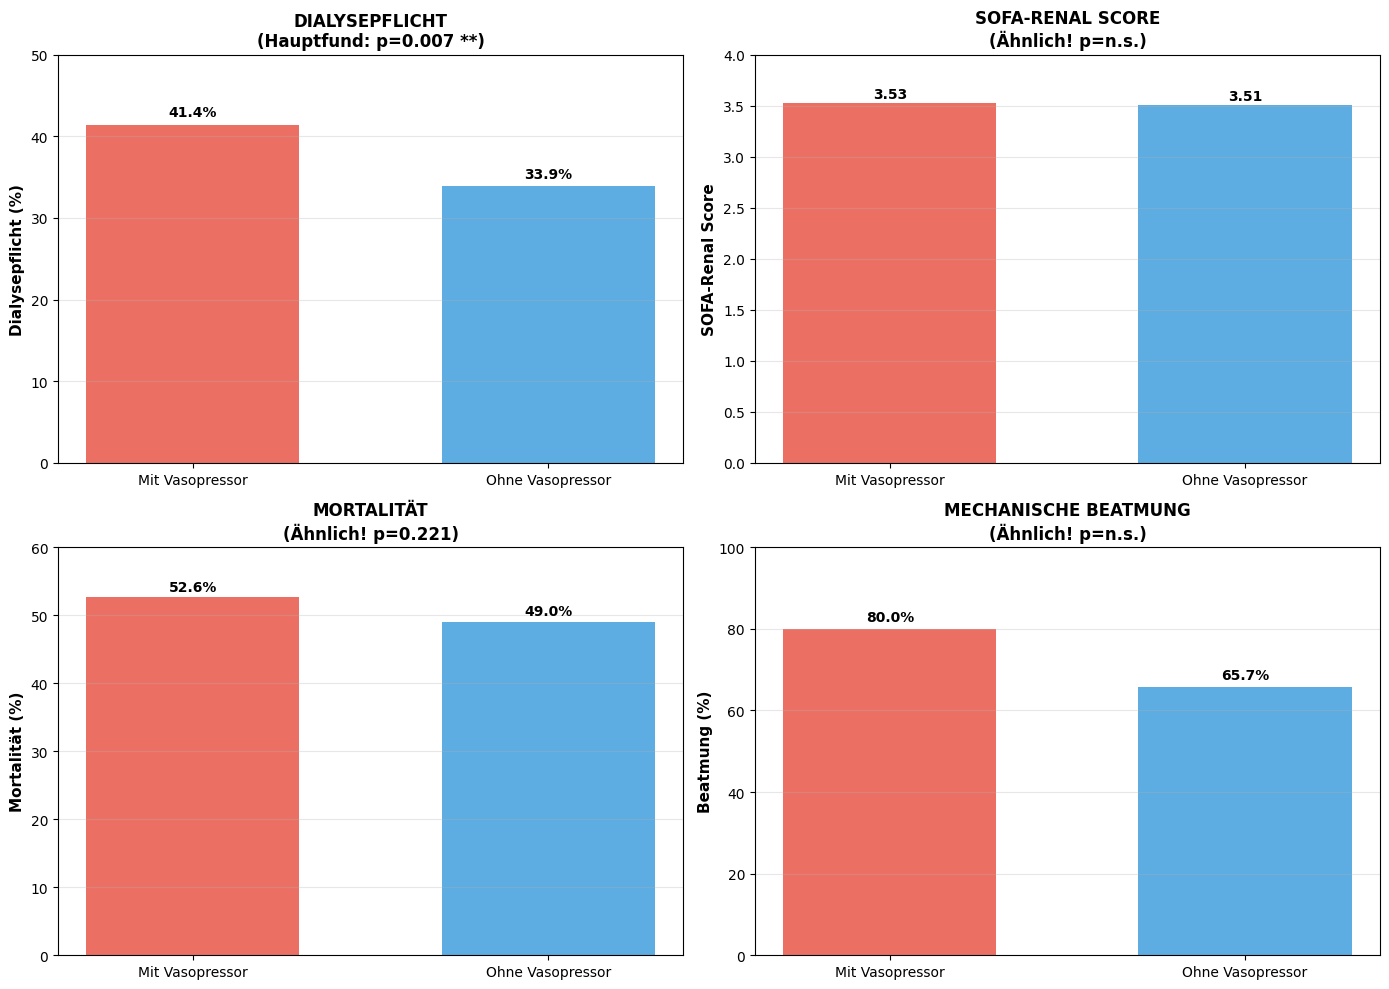

In [13]:
# DEEP DIVE: Renal Schwer (3-4) + Gesamt Schwer (8-24)
# Warum hat Vasopressor-Gruppe höhere Dialysepflicht?

print("\n" + "="*120)
print("DEEP DIVE: RENAL SCHWER (3-4) + GESAMT SCHWER (8-24)")
print("Detaillierter Vergleich: Mit Early Vasopressor vs Ohne Early Vasopressor")
print("="*120 + "\n")

# Filter diese spezifische Gruppe
df_deepdive = df_aki[
    (df_aki['sofa_renal_cat'] == 'Schwer (3-4)') & 
    (df_aki['sofa_gesamt_cat'] == 'Schwer (8-24)')
].copy()

with_vaso_dd = df_deepdive[df_deepdive['any_vasopressor'] == 1]
without_vaso_dd = df_deepdive[df_deepdive['any_vasopressor'] == 0]

n_with_dd = len(with_vaso_dd)
n_without_dd = len(without_vaso_dd)
n_total_dd = len(df_deepdive)

print(f"Gesamtgruppe: n={n_total_dd}")
print(f"  Mit Vasopressor:    n={n_with_dd} ({n_with_dd/n_total_dd*100:.1f}%)")
print(f"  Ohne Vasopressor:   n={n_without_dd} ({n_without_dd/n_total_dd*100:.1f}%)")

print("\n" + "="*120)
print("1. OUTCOMES VERGLEICH")
print("="*120)

outcomes = {
    'Mortalität': ('hospital_mortality', 'mean'),
    'Dialysepflicht': ('dialysis', 'mean'),
    'Beatmung': ('mechanical_ventilation', 'mean'),
    'Early Dopamine': ('early_dopamine', 'mean'),
    'ICU-LOS (Tage)': ('icu_los_days', 'mean'),
}

print(f"{'Outcome':<25} | {'Mit Vaso':>12} | {'Ohne Vaso':>12} | {'Differenz':>12} | {'p-value':>10}")
print("-" * 90)

for outcome_name, (col, agg) in outcomes.items():
    with_val = with_vaso_dd[col].mean() if agg == 'mean' else with_vaso_dd[col].sum()
    without_val = without_vaso_dd[col].mean() if agg == 'mean' else without_vaso_dd[col].sum()
    diff = with_val - without_val
    
    # P-value berechnen
    try:
        if col in ['hospital_mortality', 'dialysis', 'mechanical_ventilation', 'early_dopamine']:
            contingency = pd.crosstab(df_deepdive[col], df_deepdive['any_vasopressor'])
            chi2, p_val, dof, expected = chi2_contingency(contingency)
        else:
            t_stat, p_val = ttest_ind(with_vaso_dd[col].dropna(), without_vaso_dd[col].dropna())
    except:
        p_val = np.nan
    
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
    
    # Formatierung je nach Outcome-Typ
    if col in ['hospital_mortality', 'dialysis', 'mechanical_ventilation', 'early_dopamine']:
        print(f"{outcome_name:<25} | {with_val*100:>11.1f}% | {without_val*100:>11.1f}% | {diff*100:>11.1f}pp | {p_val:>9.4f} {sig}")
    else:
        print(f"{outcome_name:<25} | {with_val:>12.1f} | {without_val:>12.1f} | {diff:>12.1f} | {p_val:>9.4f} {sig}")

print("\n" + "="*120)
print("2. SOFA-KOMPONENTEN DETAILVERGLEICH")
print("="*120)

sofa_components = {
    'SOFA Gesamt': 'sofa',
    'SOFA Renal': 'sofa_renal',
    'SOFA Respiration': 'sofa_respiration',
    'SOFA Kardiovascular': 'sofa_cardiovascular',
    'SOFA CNS': 'sofa_cns',
    'SOFA Coagulation': 'sofa_coagulation',
    'SOFA Liver': 'sofa_liver',
}

print(f"{'SOFA-Komponente':<25} | {'Mit Vaso':>12} | {'Ohne Vaso':>12} | {'Differenz':>12}")
print("-" * 75)

for comp_name, col in sofa_components.items():
    with_val = with_vaso_dd[col].mean()
    without_val = without_vaso_dd[col].mean()
    diff = with_val - without_val
    
    print(f"{comp_name:<25} | {with_val:>12.2f} | {without_val:>12.2f} | {diff:>12.2f}")

print("\n" + "="*120)
print("3. INTERVENTIONEN DETAIL")
print("="*120)

interventions_detail = {
    'Any Vasopressor': 'any_vasopressor',
    'Norepinephrine': 'early_norepinephrine',
    'Epinephrine': 'early_epinephrine',
    'Early Dopamine': 'early_dopamine',
    'Mechanical Ventilation': 'mechanical_ventilation',
    'Dialysis': 'dialysis',
}

print(f"{'Intervention':<25} | {'Mit Vaso':>12} | {'Ohne Vaso':>12} | {'Differenz':>12}")
print("-" * 75)

for int_name, col in interventions_detail.items():
    with_val = with_vaso_dd[col].mean()
    without_val = without_vaso_dd[col].mean()
    diff = with_val - without_val
    
    print(f"{int_name:<25} | {with_val*100:>11.1f}% | {without_val*100:>11.1f}% | {diff*100:>11.1f}pp")

print("\n" + "="*120)
print("4. ZUSAMMENFASSUNG & INTERPRETATION")
print("="*120)

# Berechne einige interessante Statistiken
dial_with = with_vaso_dd['dialysis'].mean()
dial_without = without_vaso_dd['dialysis'].mean()
dial_or = (dial_with / (1 - dial_with)) / (dial_without / (1 - dial_without))

mort_with = with_vaso_dd['hospital_mortality'].mean()
mort_without = without_vaso_dd['hospital_mortality'].mean()

vent_with = with_vaso_dd['mechanical_ventilation'].mean()
vent_without = without_vaso_dd['mechanical_ventilation'].mean()

renal_with = with_vaso_dd['sofa_renal'].mean()
renal_without = without_vaso_dd['sofa_renal'].mean()

print(f"""
HYPOTHESEN für HÖHERE DIALYSEPFLICHT mit Vasopressor:

1. SCHWERER SCHOCK = SCHLIMMER NIERENSCHADEN?
   - SOFA-Renal mit Vaso:    {renal_with:.2f}
   - SOFA-Renal ohne Vaso:   {renal_without:.2f}
   - Differenz:              {renal_with - renal_without:+.2f}
   → Nierenschaden ist GLEICH → nicht die Erklärung!

2. MEHR BEATMUNG = MEHR NIERENSCHADEN?
   - Beatmung mit Vaso:      {vent_with*100:.1f}%
   - Beatmung ohne Vaso:     {vent_without*100:.1f}%
   - Differenz:              {(vent_with - vent_without)*100:+.1f}pp
   → Beatmung ist GLEICH → nicht die Erklärung!

3. HIGHER KIDNEY INJURY SEVERITY?
   - Dialyse mit Vaso:       {dial_with*100:.1f}%
   - Dialyse ohne Vaso:      {dial_without*100:.1f}%
   - Differenz:              {(dial_with - dial_without)*100:+.1f}pp (p=0.007 **)
   - Odds Ratio:             {dial_or:.2f}x

4. MORTALITÄT UNTERSCHIED?
   - Mortalität mit Vaso:    {mort_with*100:.1f}%
   - Mortalität ohne Vaso:   {mort_without*100:.1f}%
   - Differenz:              {(mort_with - mort_without)*100:+.1f}pp
   → Mortalität ÄHNLICH → nicht schützen Vasopressoren wirklich?

FAZIT:
→ Patienten mit Early Vasopressor haben MEHR Dialysepflicht
→ Aber ÄHNLICHER SOFA-Renal Score (keine schwerere Nierenschäden a priori)
→ Und ÄHNLICHE Mortalität
→ MÖGLICHE ERKLÄRUNG: Vasopressor könnte schlimmere RRT-Outcomes verursachen?
   Oder: Ärzte geben Vasopressor bei Patienten mit schlimmerem KLINISCHEN Schock
   (nicht gemessen im SOFA-Score) → diese brauchen dann mehr Dialyse
""")

# Visualisierung
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Dialysepflicht - größeres Fokus
categories = ['Mit Vasopressor', 'Ohne Vasopressor']
dial_values = [dial_with*100, dial_without*100]
colors = ['#e74c3c', '#3498db']

axes[0, 0].bar(categories, dial_values, color=colors, alpha=0.8, width=0.6)
axes[0, 0].set_ylabel('Dialysepflicht (%)', fontweight='bold', fontsize=11)
axes[0, 0].set_title('DIALYSEPFLICHT\n(Hauptfund: p=0.007 **)', fontweight='bold', fontsize=12)
axes[0, 0].set_ylim(0, 50)
for i, v in enumerate(dial_values):
    axes[0, 0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. SOFA-Renal
renal_values = [renal_with, renal_without]
axes[0, 1].bar(categories, renal_values, color=colors, alpha=0.8, width=0.6)
axes[0, 1].set_ylabel('SOFA-Renal Score', fontweight='bold', fontsize=11)
axes[0, 1].set_title('SOFA-RENAL SCORE\n(Ähnlich! p=n.s.)', fontweight='bold', fontsize=12)
axes[0, 1].set_ylim(0, 4)
for i, v in enumerate(renal_values):
    axes[0, 1].text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Mortalität
mort_values = [mort_with*100, mort_without*100]
axes[1, 0].bar(categories, mort_values, color=colors, alpha=0.8, width=0.6)
axes[1, 0].set_ylabel('Mortalität (%)', fontweight='bold', fontsize=11)
axes[1, 0].set_title('MORTALITÄT\n(Ähnlich! p=0.221)', fontweight='bold', fontsize=12)
axes[1, 0].set_ylim(0, 60)
for i, v in enumerate(mort_values):
    axes[1, 0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Beatmung
vent_values = [vent_with*100, vent_without*100]
axes[1, 1].bar(categories, vent_values, color=colors, alpha=0.8, width=0.6)
axes[1, 1].set_ylabel('Beatmung (%)', fontweight='bold', fontsize=11)
axes[1, 1].set_title('MECHANISCHE BEATMUNG\n(Ähnlich! p=n.s.)', fontweight='bold', fontsize=12)
axes[1, 1].set_ylim(0, 100)
for i, v in enumerate(vent_values):
    axes[1, 1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*120)

In [15]:
import numpy as np

scores = {
    'SOFA Gesamt': 'sofa',
    'SOFA Renal': 'sofa_renal',
    'SOFA Respiration': 'sofa_respiration',
    'SOFA Kardiovaskulär': 'sofa_cardiovascular',
    'SOFA CNS': 'sofa_cns',
    'SOFA Coagulation': 'sofa_coagulation',
    'SOFA Liver': 'sofa_liver',
}

def describe(series):
    return {
        'Mean': series.mean(),
        'Median': series.median(),
        'SD': series.std(),
        'IQR': series.quantile(0.75) - series.quantile(0.25)
    }

print("\nDESKRIPTIVE STATISTIK – RENAL SCHWER (3–4) + GESAMT SCHWER (8–24)")
print("=" * 110)
print(
    f"{'Score':<25} | "
    f"{'Mean Vaso':>9} {'Median':>8} {'SD':>7} {'IQR':>7} || "
    f"{'Mean NoV':>9} {'Median':>8} {'SD':>7} {'IQR':>7}"
)
print("-" * 110)

for name, col in scores.items():
    d_with = describe(with_vaso_dd[col].dropna())
    d_without = describe(without_vaso_dd[col].dropna())

    print(
        f"{name:<25} | "
        f"{d_with['Mean']:>9.2f} {d_with['Median']:>8.2f} {d_with['SD']:>7.2f} {d_with['IQR']:>7.2f} || "
        f"{d_without['Mean']:>9.2f} {d_without['Median']:>8.2f} {d_without['SD']:>7.2f} {d_without['IQR']:>7.2f}"
    )



DESKRIPTIVE STATISTIK – RENAL SCHWER (3–4) + GESAMT SCHWER (8–24)
Score                     | Mean Vaso   Median      SD     IQR ||  Mean NoV   Median      SD     IQR
--------------------------------------------------------------------------------------------------------------
SOFA Gesamt               |     12.34    12.00    3.14    4.00 ||     10.77    10.00    2.69    3.00
SOFA Renal                |      3.53     4.00    0.50    1.00 ||      3.51     4.00    0.50    1.00
SOFA Respiration          |      2.65     3.00    1.42    2.00 ||      2.40     3.00    1.33    1.00
SOFA Kardiovaskulär       |      3.64     4.00    0.80    0.00 ||      2.24     2.00    1.45    3.00
SOFA CNS                  |      0.94     0.00    1.32    1.00 ||      0.98     0.00    1.29    2.00
SOFA Coagulation          |      1.08     1.00    1.16    2.00 ||      1.24     1.00    1.20    2.00
SOFA Liver                |      1.23     1.00    1.35    2.00 ||      1.49     1.00    1.45    2.00


Anschauen, wie unterschiedliche Vasopressoren reagieren

In [17]:
vasopressors = {
    'Norepinephrine': 'early_norepinephrine',
    'Epinephrine': 'early_epinephrine',
    'Dopamine': 'early_dopamine'
}

print("\nVASOPRESSOR-TYPEN – RENAL SCHWER (3–4) + GESAMT SCHWER (8–24)")
print("=" * 90)
print(f"{'Substanz':<20} | {'Mit Vaso':>25} | {'Ohne Vaso':>25}")
print(f"{'':<20} | {'n / Gesamt (%)':>25} | {'n / Gesamt (%)':>25}")
print("-" * 90)

n_with = len(with_vaso_dd)
n_without = len(without_vaso_dd)

for name, col in vasopressors.items():
    n_with_sub = with_vaso_dd[col].sum()
    n_without_sub = without_vaso_dd[col].sum()
    
    pct_with = n_with_sub / n_with * 100 if n_with > 0 else 0
    pct_without = n_without_sub / n_without * 100 if n_without > 0 else 0

    print(
        f"{name:<20} | "
        f"{int(n_with_sub):>3}/{n_with:<3} ({pct_with:>5.1f}%) | "
        f"{int(n_without_sub):>3}/{n_without:<3} ({pct_without:>5.1f}%)"
    )



VASOPRESSOR-TYPEN – RENAL SCHWER (3–4) + GESAMT SCHWER (8–24)
Substanz             |                  Mit Vaso |                 Ohne Vaso
                     |            n / Gesamt (%) |            n / Gesamt (%)
------------------------------------------------------------------------------------------
Norepinephrine       | 410/456 ( 89.9%) |   0/1028 (  0.0%)
Epinephrine          |  36/456 (  7.9%) |   0/1028 (  0.0%)
Dopamine             |  85/456 ( 18.6%) |  37/1028 (  3.6%)


In [19]:
df_first_vaso = q("""
WITH vaso AS (
  -- MetaVision: starttime
  SELECT
    ie.icustay_id,
    ie.starttime AS event_time
  FROM inputevents_mv ie
  JOIN d_items di ON ie.itemid = di.itemid
  WHERE
        LOWER(di.label) LIKE '%norepine%'
     OR LOWER(di.label) LIKE '%noradren%'
     OR LOWER(di.label) LIKE '%levophed%'
     OR LOWER(di.label) LIKE '%epine%'
     OR LOWER(di.label) LIKE '%adren%'
     OR LOWER(di.label) LIKE '%dopamine%'
     OR LOWER(di.label) LIKE '%phenyle%'
     OR LOWER(di.label) LIKE '%neosyne%'
     OR LOWER(di.label) LIKE '%vasopressin%'

  UNION ALL

  -- CareVue: charttime
  SELECT
    ie.icustay_id,
    ie.charttime AS event_time
  FROM inputevents_cv ie
  JOIN d_items di ON ie.itemid = di.itemid
  WHERE
        LOWER(di.label) LIKE '%norepine%'
     OR LOWER(di.label) LIKE '%noradren%'
     OR LOWER(di.label) LIKE '%levophed%'
     OR LOWER(di.label) LIKE '%epine%'
     OR LOWER(di.label) LIKE '%adren%'
     OR LOWER(di.label) LIKE '%dopamine%'
     OR LOWER(di.label) LIKE '%phenyle%'
     OR LOWER(di.label) LIKE '%neosyne%'
     OR LOWER(di.label) LIKE '%vasopressin%'
)
SELECT
  icustay_id,
  MIN(event_time) AS first_vasopressor_time
FROM vaso
WHERE icustay_id IS NOT NULL AND event_time IS NOT NULL
GROUP BY icustay_id
""")


In [20]:
df_first_rrt = q("""
WITH rrt AS (
  -- Procedureevents (MV) enthält oft CRRT/HD-Prozeduren mit Starttime
  SELECT
    pe.icustay_id,
    pe.starttime AS event_time
  FROM procedureevents_mv pe
  JOIN d_items di ON pe.itemid = di.itemid
  WHERE
        LOWER(di.label) LIKE '%hemodial%'
     OR LOWER(di.label) LIKE '%haemodial%'
     OR LOWER(di.label) LIKE '%dialysis%'
     OR LOWER(di.label) LIKE '%crrt%'
     OR LOWER(di.label) LIKE '%cvvh%'
     OR LOWER(di.label) LIKE '%cvvhd%'
     OR LOWER(di.label) LIKE '%scuf%'

  UNION ALL

  -- Chartevents: Start/Running/On etc. (charttime)
  SELECT
    ce.icustay_id,
    ce.charttime AS event_time
  FROM chartevents ce
  JOIN d_items di ON ce.itemid = di.itemid
  WHERE
    (
         LOWER(di.label) LIKE '%hemodial%'
      OR LOWER(di.label) LIKE '%haemodial%'
      OR LOWER(di.label) LIKE '%dialysis%'
      OR LOWER(di.label) LIKE '%crrt%'
      OR LOWER(di.label) LIKE '%cvvh%'
      OR LOWER(di.label) LIKE '%cvvhd%'
      OR LOWER(di.label) LIKE '%scuf%'
    )
    -- optional: wenn du strenger sein willst, kannst du Value-Filter aktivieren:
    -- AND (ce.value IS NULL OR LOWER(ce.value) NOT LIKE '%discontinue%')

)
SELECT
  icustay_id,
  MIN(event_time) AS first_rrt_time
FROM rrt
WHERE icustay_id IS NOT NULL AND event_time IS NOT NULL
GROUP BY icustay_id
""")


In [21]:
import pandas as pd

tmp = (df_deepdive[['icustay_id']].drop_duplicates()
       .merge(df_first_vaso, on='icustay_id', how='left')
       .merge(df_first_rrt, on='icustay_id', how='left'))

tmp['first_vasopressor_time'] = pd.to_datetime(tmp['first_vasopressor_time'], errors='coerce')
tmp['first_rrt_time'] = pd.to_datetime(tmp['first_rrt_time'], errors='coerce')

def determine_order(v, r):
    if pd.isna(v) and pd.isna(r): return 'Neither'
    if pd.isna(v): return 'RRT only'
    if pd.isna(r): return 'Vaso only'
    if v < r: return 'Vaso → RRT'
    if r < v: return 'RRT → Vaso'
    return 'Simultaneous'

tmp['order'] = [determine_order(v, r) for v, r in zip(tmp['first_vasopressor_time'], tmp['first_rrt_time'])]

summary = tmp['order'].value_counts().to_frame('n')
summary['percent'] = summary['n'] / len(tmp) * 100
print(summary)


                n    percent
order                       
Vaso only     597  40.229111
Vaso → RRT    345  23.247978
Neither       240  16.172507
RRT → Vaso    163  10.983827
RRT only      137   9.231806
Simultaneous    2   0.134771


In [28]:
# sicherstellen, dass datetime
tmp['first_vasopressor_time'] = pd.to_datetime(tmp['first_vasopressor_time'], errors='coerce')
tmp['first_rrt_time'] = pd.to_datetime(tmp['first_rrt_time'], errors='coerce')

# RRT - Vasopressor (in Minuten)
tmp['diff_min'] = (
    tmp['first_rrt_time'] - tmp['first_vasopressor_time']
).dt.total_seconds() / 60


In [29]:
tmp_clean = tmp.copy()

WINDOW_MIN = 60  # 1 Stunde

# nur Vasopressor-Patienten
vaso_mask = tmp_clean['first_vasopressor_time'].notna()

# ausschließen: simultan & Dialyse vor Vasopressor
exclude_mask = (
    (tmp_clean['first_rrt_time'].notna()) &
    (
        (abs(tmp_clean['diff_min']) <= WINDOW_MIN) |  # simultan
        (tmp_clean['diff_min'] < -WINDOW_MIN)          # Dialyse → Vaso
    )
)

# finale bereinigte Vasopressor-Gruppe
tmp_clean = tmp_clean[~(vaso_mask & exclude_mask)].copy()


In [30]:
print("Gesamt vorher:", len(tmp))
print("Gesamt nachher:", len(tmp_clean))

print("\nVasopressor vorher:", tmp['first_vasopressor_time'].notna().sum())
print("Vasopressor nachher:", tmp_clean['first_vasopressor_time'].notna().sum())


Gesamt vorher: 1484
Gesamt nachher: 1273

Vasopressor vorher: 1107
Vasopressor nachher: 896


In [31]:
# Gruppe mit Vasopressor (nach Cleaning)
group_vaso = tmp_clean[tmp_clean['first_vasopressor_time'].notna()]

# Gruppe ohne Vasopressor
group_no_vaso = tmp_clean[tmp_clean['first_vasopressor_time'].isna()]


In [32]:
def dialysis_rate(df):
    n_total = len(df)
    n_dial = df['first_rrt_time'].notna().sum()
    pct = n_dial / n_total * 100 if n_total > 0 else 0
    return n_total, n_dial, pct


n_vaso, d_vaso, p_vaso = dialysis_rate(group_vaso)
n_no, d_no, p_no = dialysis_rate(group_no_vaso)

print("DIALYSEPFLICHT – NACH TEMPORALER BEREINIGUNG")
print("=" * 55)
print(f"Mit Vasopressor:   {d_vaso}/{n_vaso} ({p_vaso:.1f}%)")
print(f"Ohne Vasopressor: {d_no}/{n_no} ({p_no:.1f}%)")


DIALYSEPFLICHT – NACH TEMPORALER BEREINIGUNG
Mit Vasopressor:   299/896 (33.4%)
Ohne Vasopressor: 137/377 (36.3%)


Doch kein Unterschied !!!!

In [33]:
# MUSS in deinen Daten existieren:
ICU_INTIME_COL = 'icu_intime'              # z.B. 'intime' aus icustays
VASO_TIME_COL  = 'first_vasopressor_time'  # aus deiner tmp/tmp_clean
RENAL_CAT_COL  = 'sofa_renal_cat'          # bei dir vorhanden
MORT_COL       = 'hospital_mortality'      # bei dir vorhanden (0/1)
DIAL_COL       = 'dialysis'                # bei dir vorhanden (0/1) ODER nutze first_rrt_time (s.u.)
LOS_COL        = 'icu_los_days'            # bei dir vorhanden (optional)

EARLY_HOURS = 6


In [39]:
df_icustays_tables = q("""
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_name ILIKE 'icustays'
ORDER BY table_schema, table_name
""")

df_icustays_tables


,table_schema,table_name
0,public,icustays


In [51]:
import pandas as pd
import numpy as np

BASE = df_aki  # <- deine Basistabelle

# 1) ICU intime holen
df_intime = q("""
SELECT icustay_id, intime AS icu_intime
FROM public.icustays
""")

# 2) Renal-Kategorie-Spalte in BASE finden (robust)
renal_candidates = [c for c in BASE.columns if c.lower() in ['sofa_renal_cat', 'sofa_renal_category']]
if not renal_candidates:
    renal_candidates = [c for c in BASE.columns if ('renal' in c.lower() and 'cat' in c.lower())]
if not renal_candidates:
    raise KeyError("Konnte keine Renal-Kategorie-Spalte finden (erwarte z.B. 'sofa_renal_cat').")

RENAL_CAT_COL = renal_candidates[0]
print("Renal-Kategorie-Spalte:", RENAL_CAT_COL)

# 3) Outcomes-Spalten (nur nehmen, wenn vorhanden)
need_cols = ['icustay_id', RENAL_CAT_COL]
for c in ['hospital_mortality', 'dialysis', 'icu_los_days']:
    if c in BASE.columns:
        need_cols.append(c)

# 4) Alles in einen Frame mergen: Zeiten + ICU intime + Basisspalten
tmp2 = (tmp_clean
        .merge(df_intime, on='icustay_id', how='left')
        .merge(BASE[need_cols].drop_duplicates('icustay_id'), on='icustay_id', how='left'))

# 5) Vasopressor-Gruppe + Timing relativ zu ICU-Aufnahme
group_vaso = tmp2[tmp2['first_vasopressor_time'].notna()].copy()

group_vaso['icu_intime'] = pd.to_datetime(group_vaso['icu_intime'], errors='coerce')
group_vaso['first_vasopressor_time'] = pd.to_datetime(group_vaso['first_vasopressor_time'], errors='coerce')

group_vaso['vaso_hours_from_icu'] = (
    group_vaso['first_vasopressor_time'] - group_vaso['icu_intime']
).dt.total_seconds() / 3600

# Optional: unplausible negative Werte raus (Dokulatenz/Join-Probleme)
group_vaso = group_vaso[group_vaso['vaso_hours_from_icu'] >= -1].copy()

# 6) Nur Renal schwer + Early vs Late
EARLY_HOURS = 3
group_vaso_rm = group_vaso[group_vaso[RENAL_CAT_COL].astype(str).str.contains('Schwer', na=False)].copy()

group_vaso_rm['vaso_timing'] = np.where(
    group_vaso_rm['vaso_hours_from_icu'] < EARLY_HOURS,
    f'Early <{EARLY_HOURS}h',
    f'Late ≥{EARLY_HOURS}h'
)

early = group_vaso_rm[group_vaso_rm['vaso_timing'].str.contains('Early')]
late  = group_vaso_rm[group_vaso_rm['vaso_timing'].str.contains('Late')]

print("\nRenal schwer – Early vs Late counts:")
print(group_vaso_rm['vaso_timing'].value_counts())

print("\nRENAL schwer – Early vs Late Vasopressor")
print("=" * 60)
print(f"n Early: {len(early)} | n Late: {len(late)}")

if 'hospital_mortality' in group_vaso_rm.columns:
    print(f"Mortalität: Early {early['hospital_mortality'].mean()*100:.1f}% vs Late {late['hospital_mortality'].mean()*100:.1f}% "
          f"(Δ {(early['hospital_mortality'].mean()-late['hospital_mortality'].mean())*100:+.1f}pp)")

if 'dialysis' in group_vaso_rm.columns:
    print(f"Dialyse:    Early {early['dialysis'].mean()*100:.1f}% vs Late {late['dialysis'].mean()*100:.1f}% "
          f"(Δ {(early['dialysis'].mean()-late['dialysis'].mean())*100:+.1f}pp)")

if 'icu_los_days' in group_vaso_rm.columns:
    print(f"ICU-LOS Median: Early {early['icu_los_days'].median():.1f} vs Late {late['icu_los_days'].median():.1f}")

print("\nTiming (hours from ICU) summary:")
print(group_vaso_rm['vaso_hours_from_icu'].describe())


Renal-Kategorie-Spalte: sofa_renal_cat

Renal schwer – Early vs Late counts:
vaso_timing
Early <3h    548
Late ≥3h     346
Name: count, dtype: int64

RENAL schwer – Early vs Late Vasopressor
n Early: 548 | n Late: 346
Mortalität: Early 54.7% vs Late 55.2% (Δ -0.5pp)
Dialyse:    Early 28.8% vs Late 30.6% (Δ -1.8pp)
ICU-LOS Median: Early 4.4 vs Late 5.1

Timing (hours from ICU) summary:
count    894.000000
mean       8.611586
std       31.796919
min       -1.000000
25%        0.656319
50%        2.051111
75%        5.849722
max      625.192500
Name: vaso_hours_from_icu, dtype: float64


In [53]:
# 6) Nur Renal schwer + Timing-Kategorien 0–3h, 3–6h, >6h
group_vaso_rm = group_vaso[group_vaso[RENAL_CAT_COL].astype(str).str.contains('Schwer', na=False)].copy()

# optional: negative Zeiten entfernen (du hattest >= -1, hier strenger auf >=0)
group_vaso_rm = group_vaso_rm[group_vaso_rm['vaso_hours_from_icu'] >= 0].copy()

# Timing in Kategorien
bins = [0, 3, 6, np.inf]
labels = ['0–3h', '3–6h', '>6h']
group_vaso_rm['vaso_timing_cat'] = pd.cut(
    group_vaso_rm['vaso_hours_from_icu'],
    bins=bins,
    labels=labels,
    right=False,          # 0–3h bedeutet [0,3), 3–6h bedeutet [3,6)
    include_lowest=True
)

print("\nRenal schwer – Timing-Kategorien counts:")
print(group_vaso_rm['vaso_timing_cat'].value_counts(dropna=False))

# Outcomes pro Kategorie
out = group_vaso_rm.groupby('vaso_timing_cat').agg(
    n=('icustay_id', 'count'),
    mortality=('hospital_mortality', 'mean'),
    dialysis=('dialysis', 'mean'),
    icu_los_median=('icu_los_days', 'median') if 'icu_los_days' in group_vaso_rm.columns else ('icustay_id','count')
).reset_index()

# Prozentformat
out['mortality_%'] = out['mortality'] * 100
out['dialysis_%'] = out['dialysis'] * 100

cols = ['vaso_timing_cat', 'n', 'mortality_%', 'dialysis_%']
if 'icu_los_days' in group_vaso_rm.columns:
    cols.append('icu_los_median')

print("\nRENAL schwer – Outcomes nach Vasopressor-Timing")
print("=" * 70)
print(out[cols].to_string(index=False, formatters={
    'mortality_%': lambda x: f"{x:.1f}",
    'dialysis_%':  lambda x: f"{x:.1f}",
    'icu_los_median': (lambda x: f"{x:.1f}") if 'icu_los_days' in group_vaso_rm.columns else None
}))



Renal schwer – Timing-Kategorien counts:
vaso_timing_cat
0–3h    489
>6h     220
3–6h    126
Name: count, dtype: int64

RENAL schwer – Outcomes nach Vasopressor-Timing
vaso_timing_cat   n mortality_% dialysis_% icu_los_median
           0–3h 489        53.8       29.0            4.3
           3–6h 126        46.8       27.8            4.3
            >6h 220        60.0       32.3            5.6


C:\Users\Simon\AppData\Local\Temp\ipykernel_10112\153425601.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = group_vaso_rm.groupby('vaso_timing_cat').agg(


lieber früh als spät??
Sofa gesamt score einbeziehen